In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"]="0.0"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import mediapipe as mp
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# relevant code is taken from video_predictor_example
# since this builds on the 'hand' preprocessing for that

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


<!-- Adding Checkpoints -->

In [5]:
from sam2.build_sam import build_sam2_video_predictor

In [6]:
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [7]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

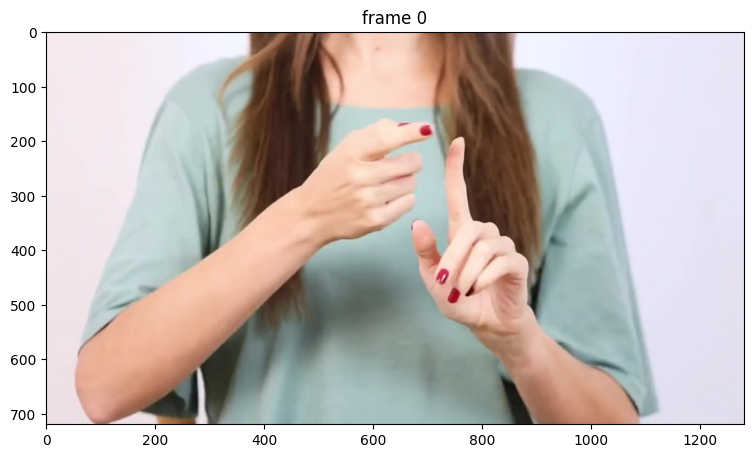

In [8]:
video_dir = "Frames"

frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [9]:
with torch.no_grad():
    inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 210/210 [00:11<00:00, 17.71it/s]


In [10]:
predictor.reset_state(inference_state)

<!-- Add Clicks -->

I0000 00:00:1737935148.942570 1605238 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737935148.984926 1606431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737935149.001289 1606431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737935149.042277 1606433 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


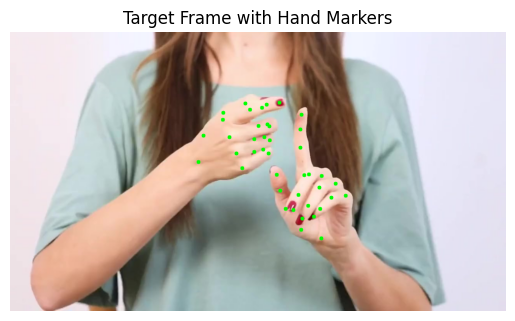

In [11]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

frame = cv2.imread('Frames/00000.jpg')  # Example, replace with actual frame loading logic
frame_pointed = frame.copy()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

results = hands.process(frame_rgb)
points = []
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        for landmark in hand_landmarks.landmark:
            x, y = int(landmark.x * frame_pointed.shape[1]), int(landmark.y * frame_pointed.shape[0])
            points.append(tuple((x,y)))
            cv2.circle(frame_pointed, (x, y), 5, (0, 255, 0), -1)  # Draw a circle for each landmark


plt.imshow(cv2.cvtColor(frame_pointed, cv2.COLOR_BGR2RGB))
plt.title("Target Frame with Hand Markers")
plt.axis('off')
plt.show()

In [12]:
print(points)
# lets take about ~6 of these for brevity's sake
# when processing many videos cutting down the number of points could help with processing times
# since 2 were enough in the video example

[(486, 335), (499, 267), (550, 208), (607, 184), (650, 195), (549, 226), (619, 200), (662, 187), (695, 182), (566, 271), (669, 243), (664, 238), (641, 242), (584, 313), (670, 279), (656, 271), (630, 276), (599, 351), (667, 313), (653, 303), (630, 309), (803, 532), (751, 510), (711, 456), (697, 409), (688, 368), (759, 369), (749, 298), (749, 251), (752, 213), (804, 371), (771, 367), (744, 420), (731, 459), (840, 391), (798, 401), (769, 448), (754, 481), (866, 422), (829, 427), (800, 456), (784, 476)]


In [13]:
shuffled = random.shuffle(points)
points = points[:6]

In [14]:
print(points)

[(771, 367), (630, 276), (549, 226), (670, 279), (653, 303), (784, 476)]


In [15]:
ann_frame_idx = 0  #the frame index we interact with
ann_obj_id = 1  #unique id

points = np.array(points, dtype=np.float32)
# coverting to the type the other example used

In [16]:
print(points)

[[771. 367.]
 [630. 276.]
 [549. 226.]
 [670. 279.]
 [653. 303.]
 [784. 476.]]


In [17]:
labels = np.array([1, 1, 1, 1, 1, 1], np.int32)

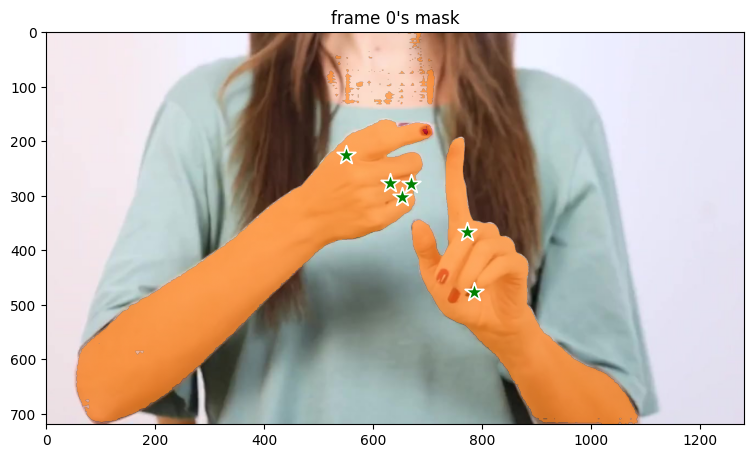

In [18]:
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)


plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}'s mask")
show_points(points, labels, plt.gca())
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

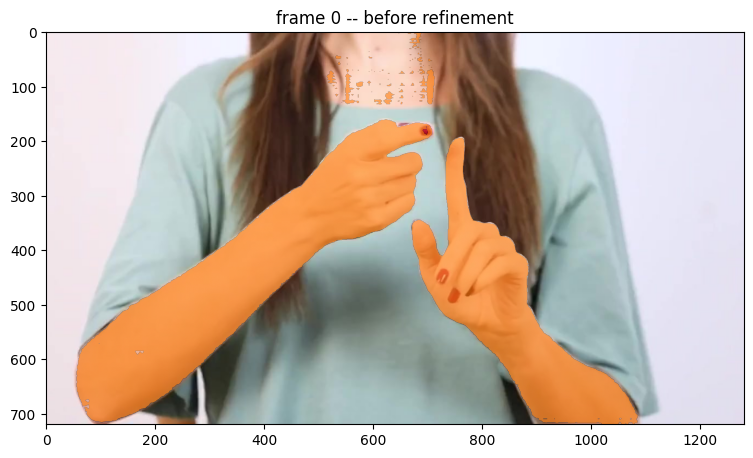

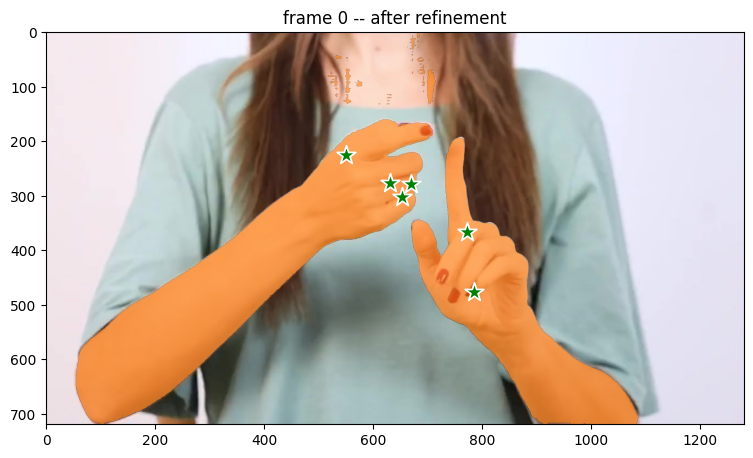

In [19]:
#show the segment before further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[0])))
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])


#adding a negative click on the neck
neg_points = np.array([[600, 100]], dtype=np.float32)
neg_labels = np.array([0], np.int32)
_, _, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

#show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[0])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

In [20]:
# since we need to send all the points to the predictor
points = np.vstack([points, neg_points])
labels = np.array([1, 1, 1, 1, 1, 1, 0], np.int32)

In [21]:
print(points, labels)

[[771. 367.]
 [630. 276.]
 [549. 226.]
 [670. 279.]
 [653. 303.]
 [784. 476.]
 [600. 100.]] [1 1 1 1 1 1 0]


In [22]:
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

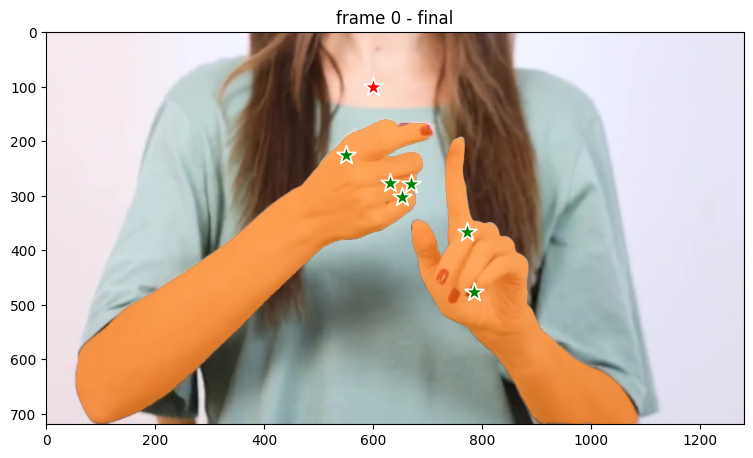

In [23]:
#show the final frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} - final")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[0])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

propagate in video: 100%|██████████| 210/210 [42:56<00:00, 12.27s/it]


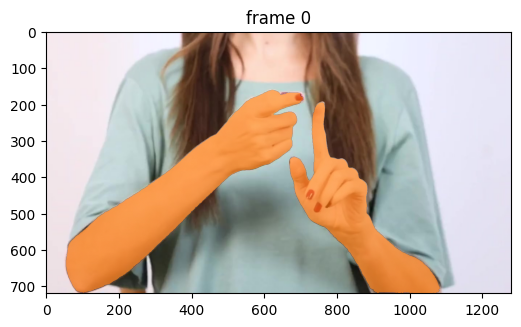

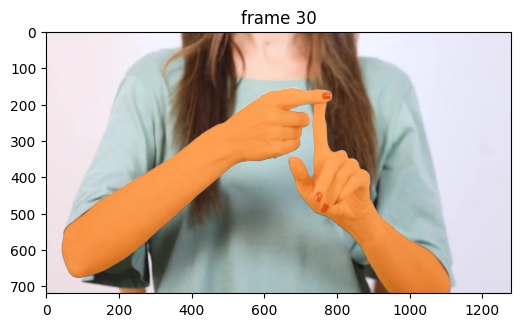

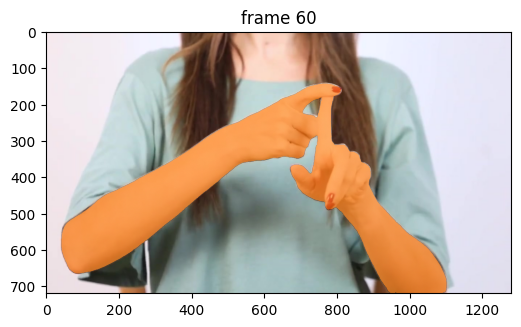

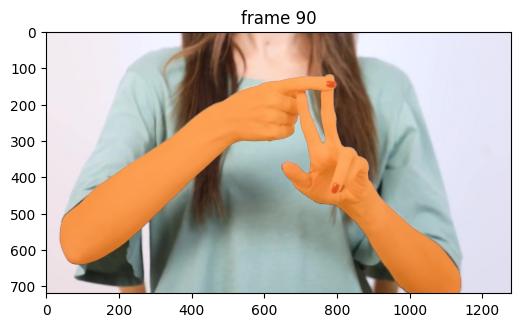

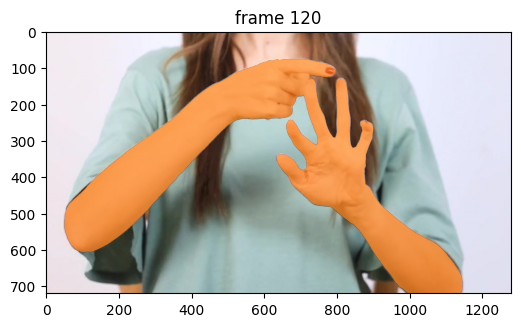

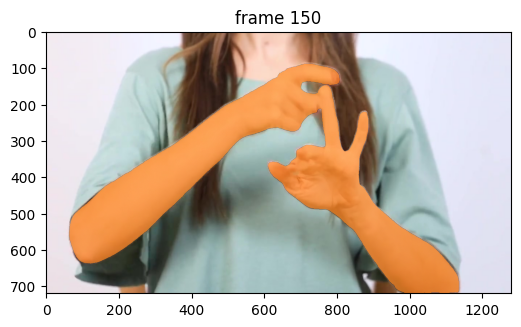

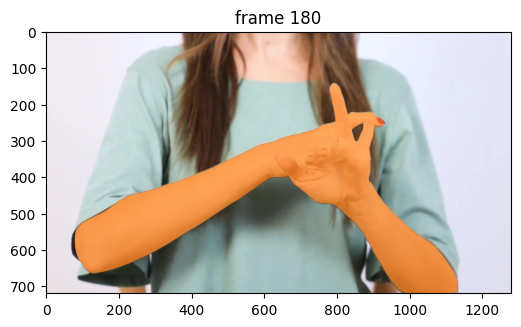

In [24]:
#add all frames, masked, to a dict while propagation
video_segments = {}  
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

video saved in output_video.mp4


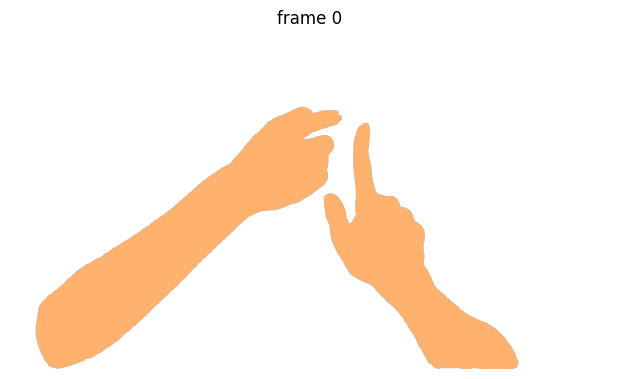

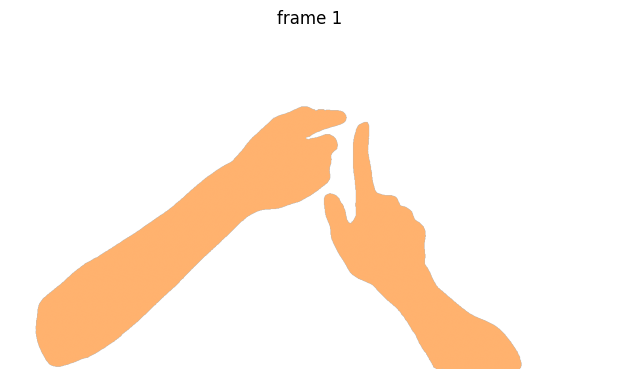

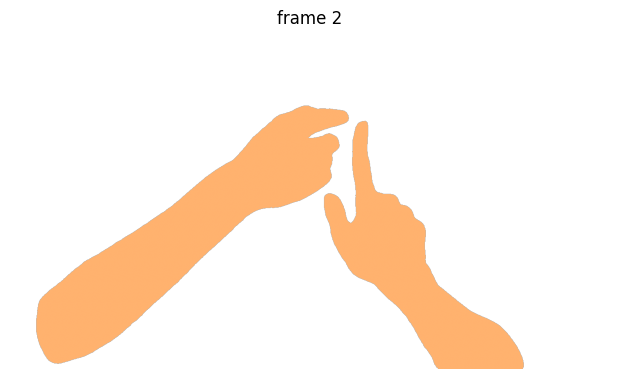

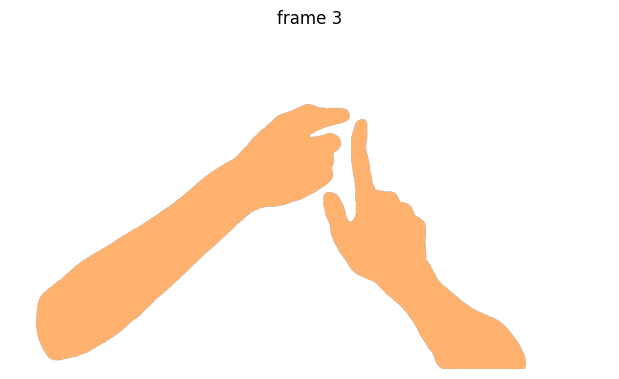

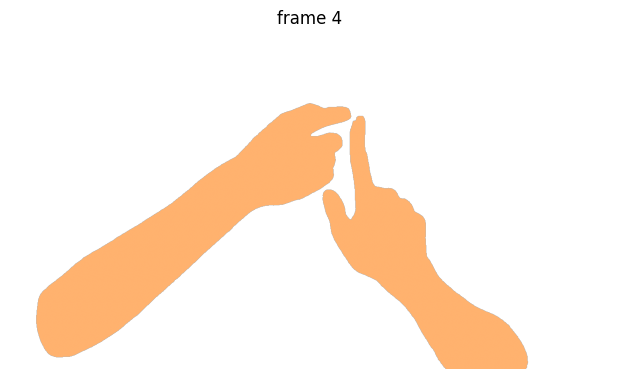

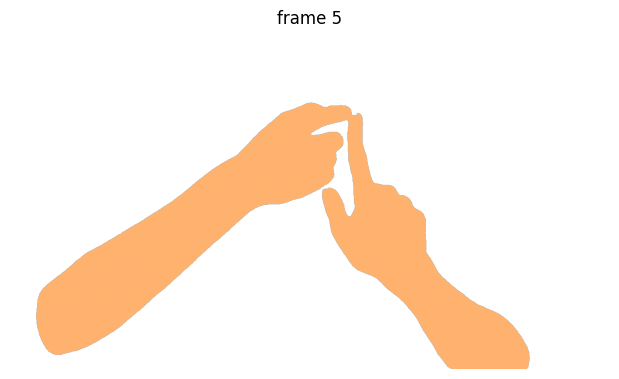

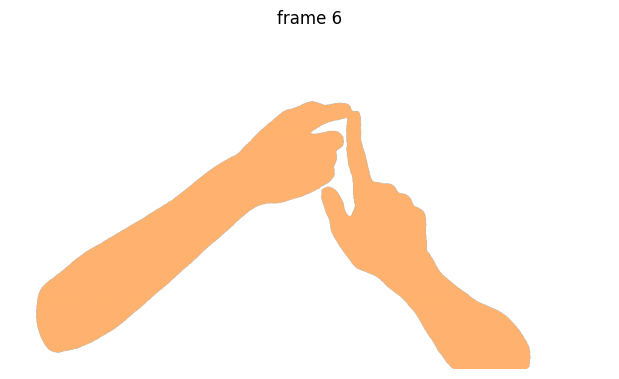

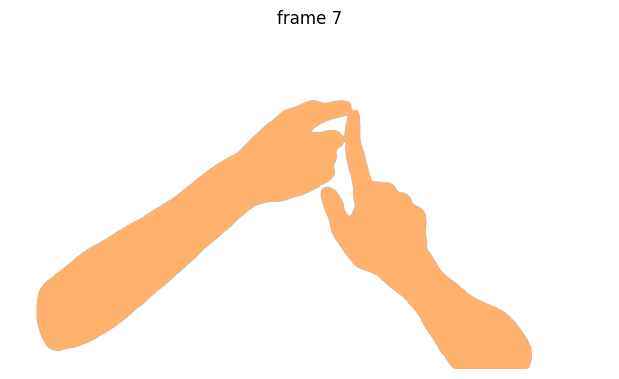

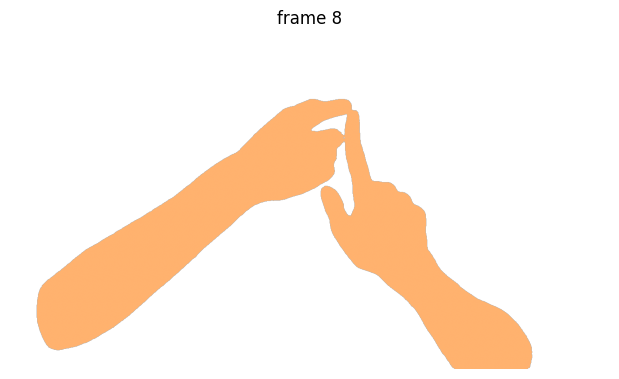

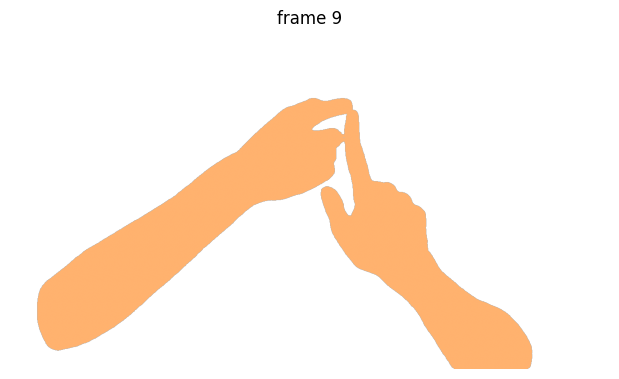

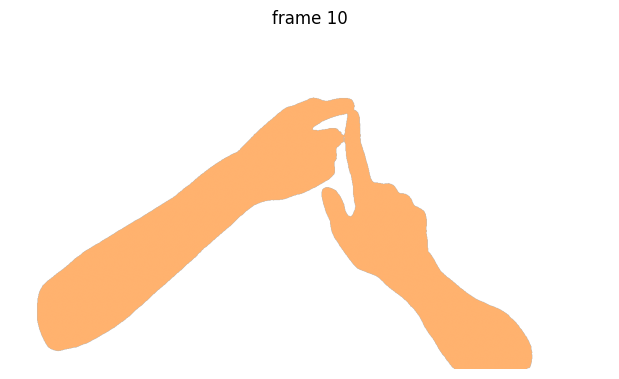

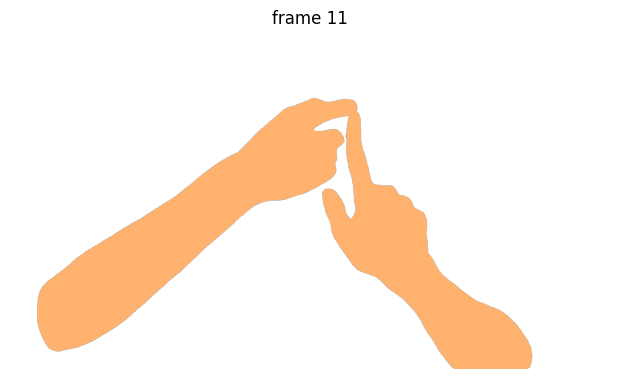

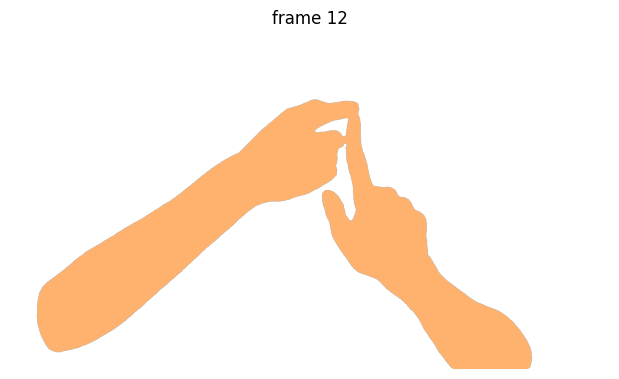

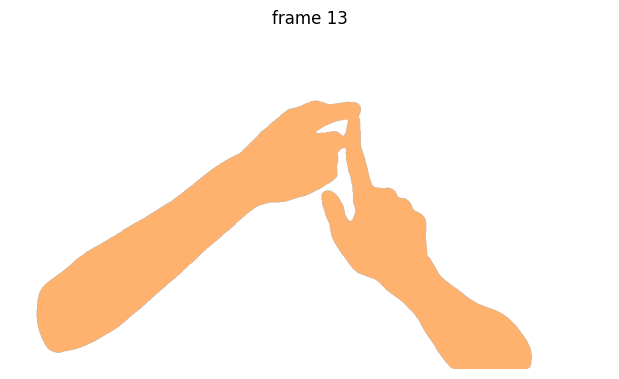

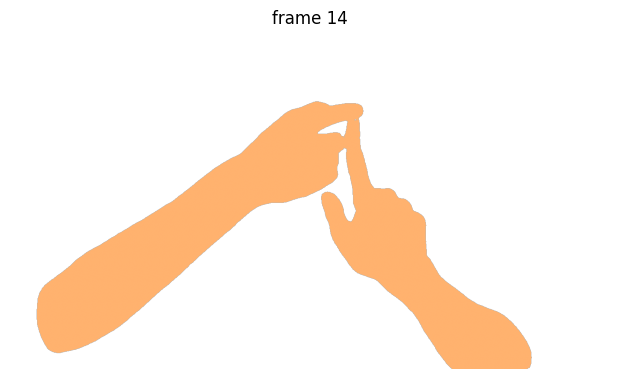

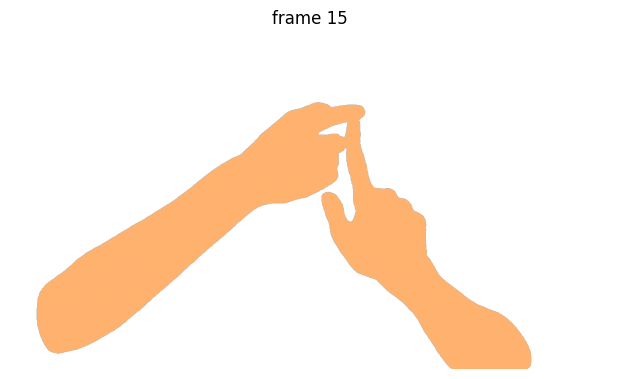

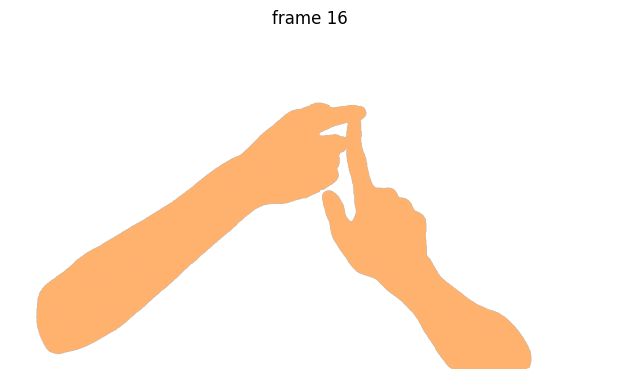

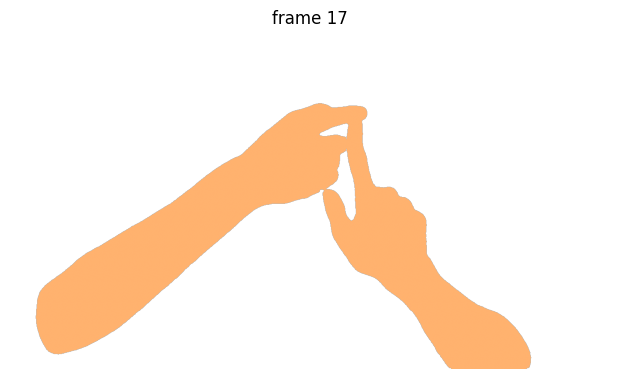

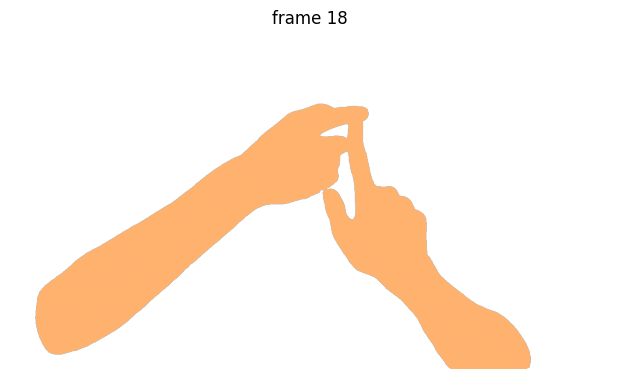

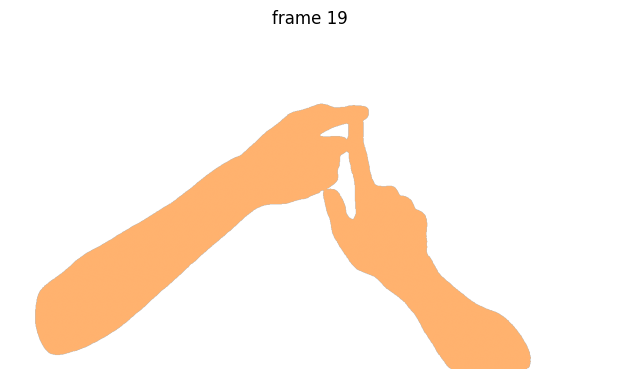

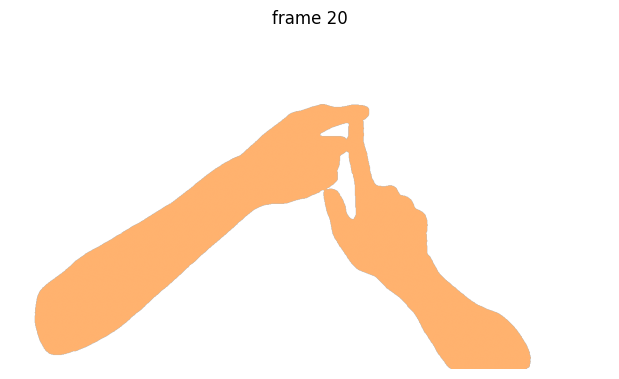

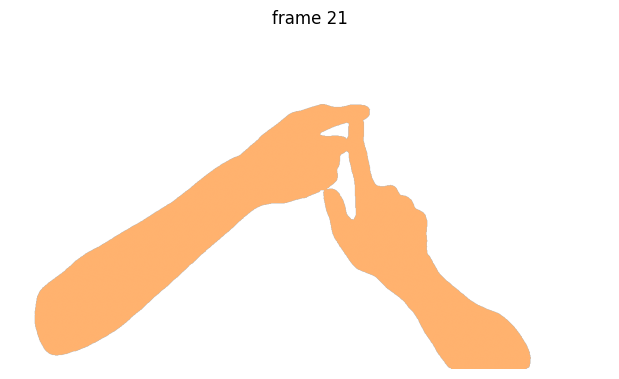

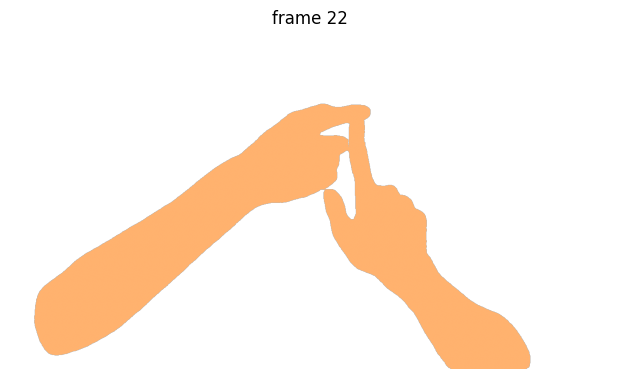

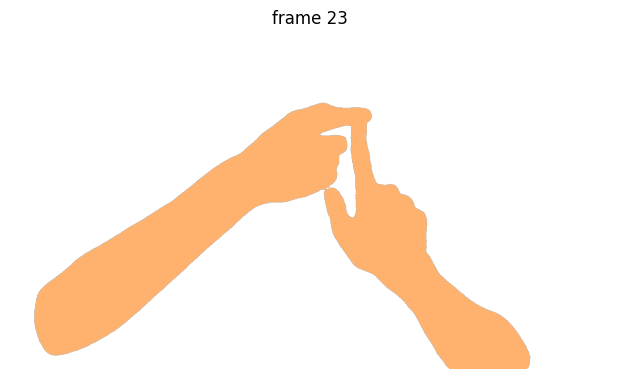

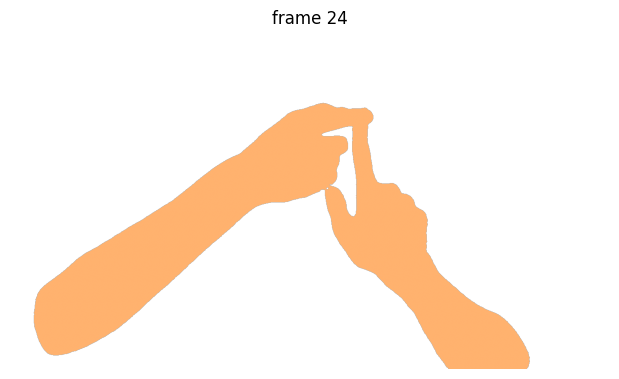

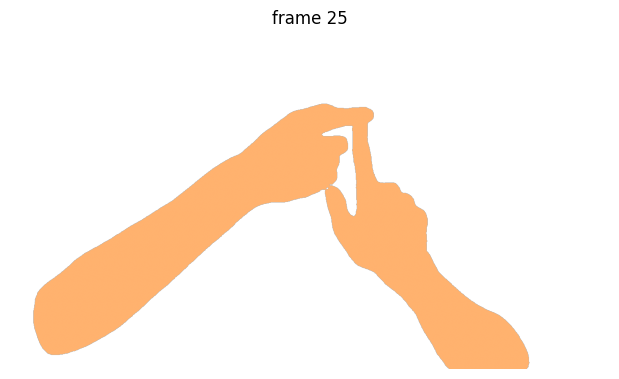

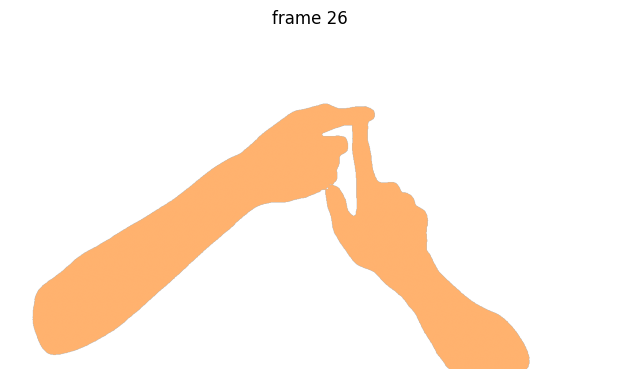

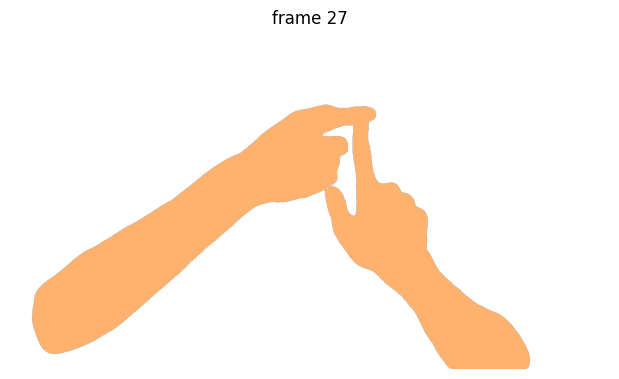

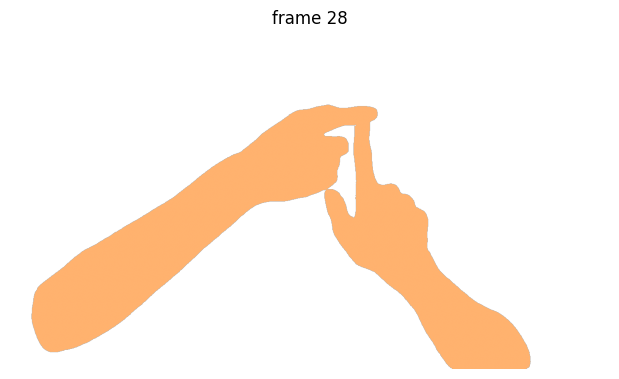

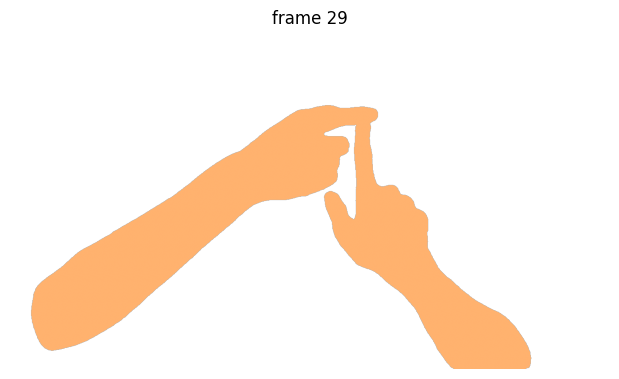

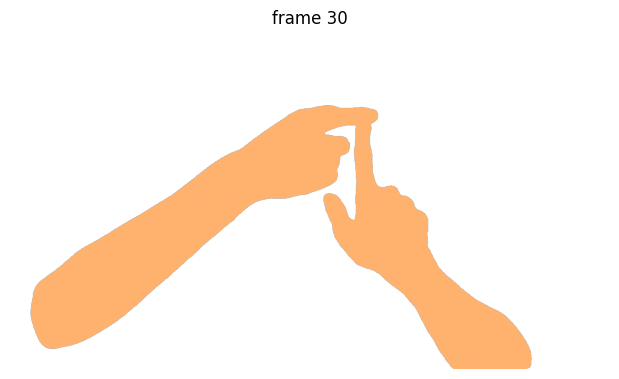

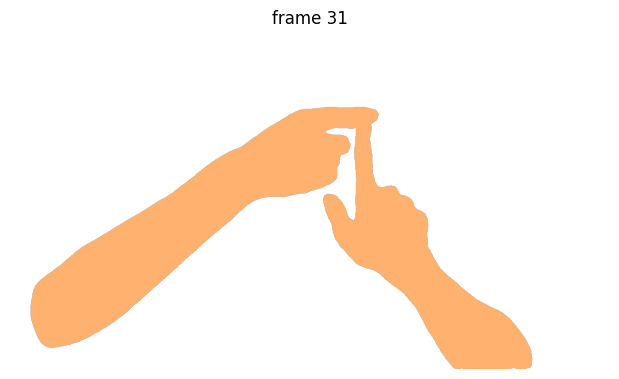

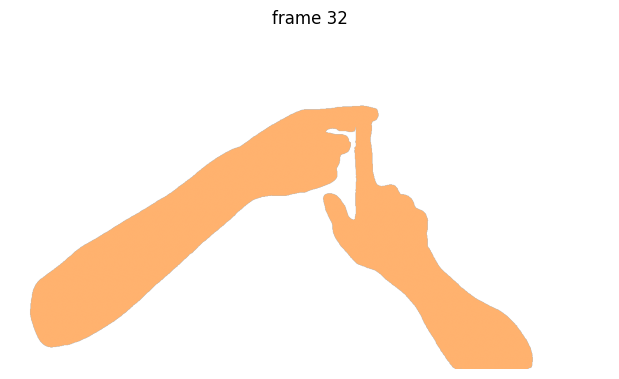

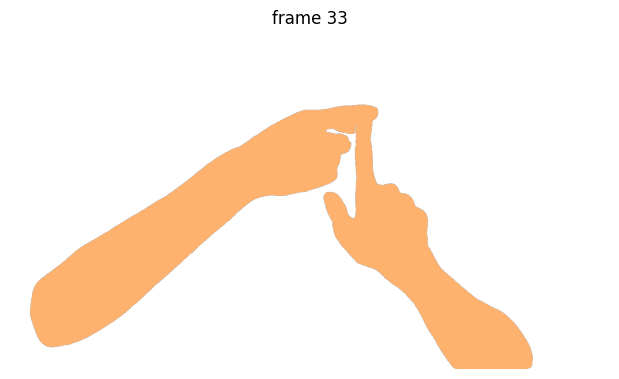

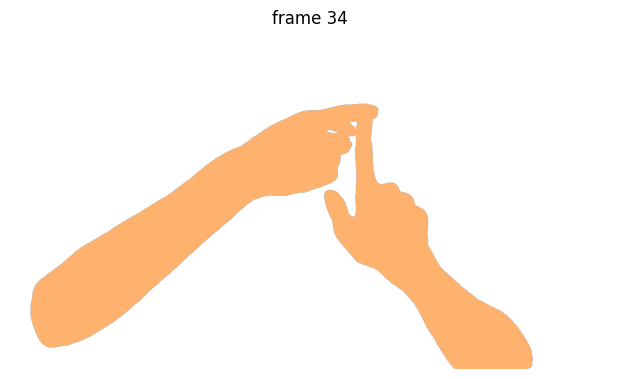

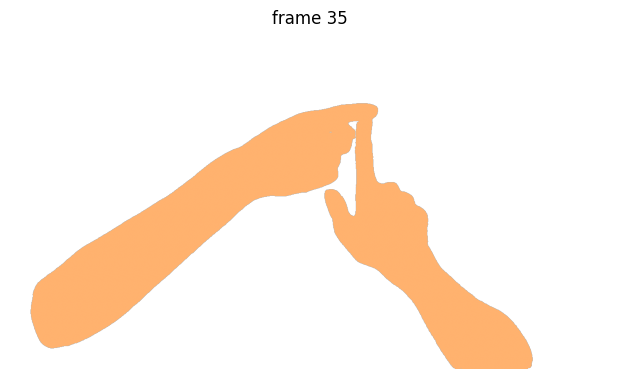

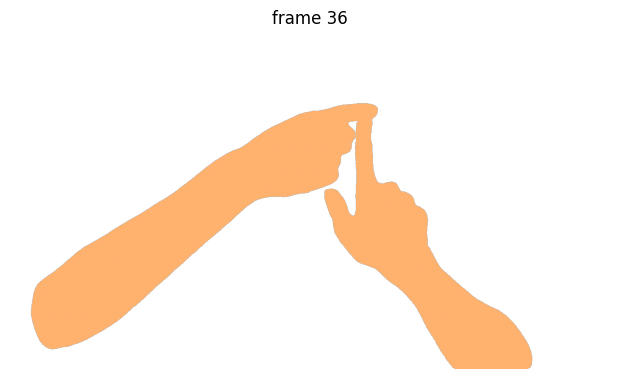

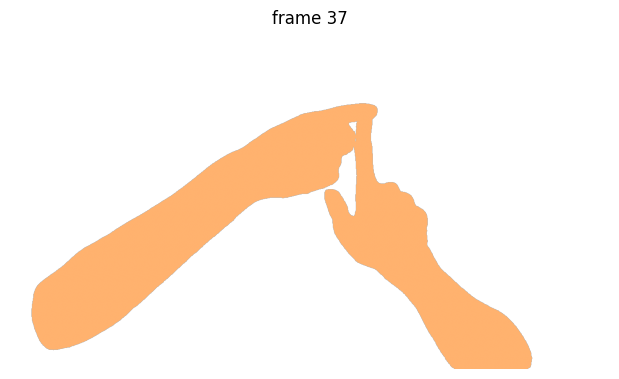

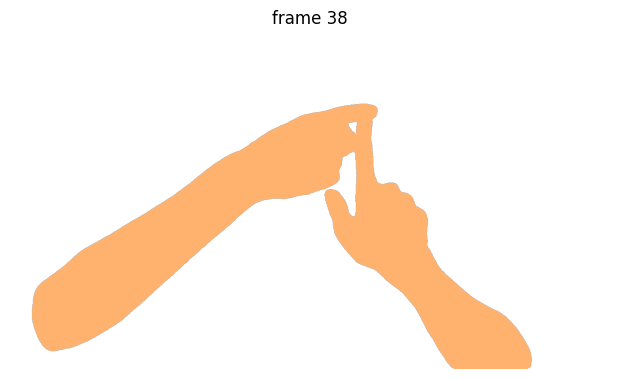

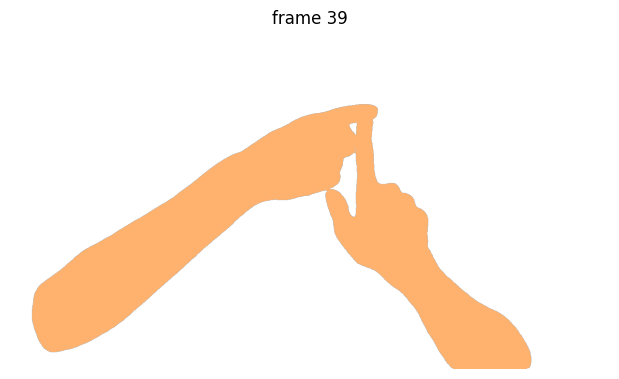

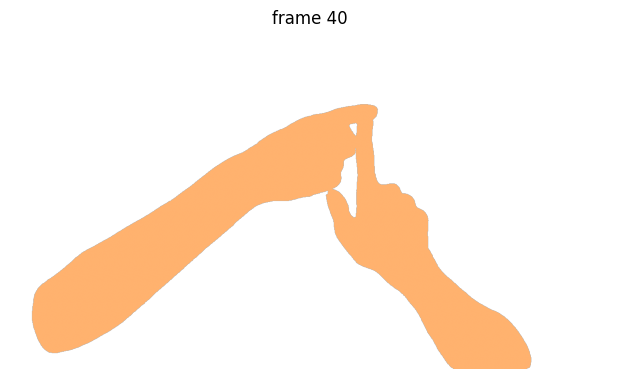

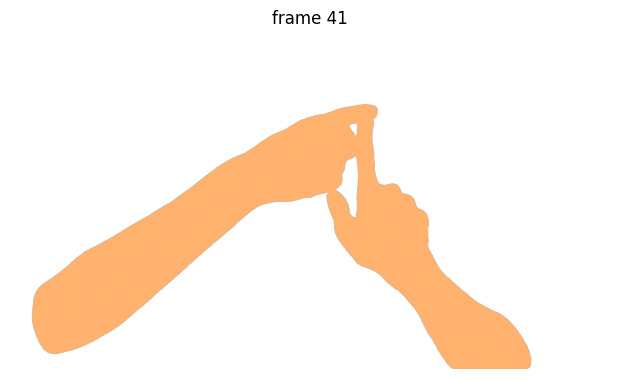

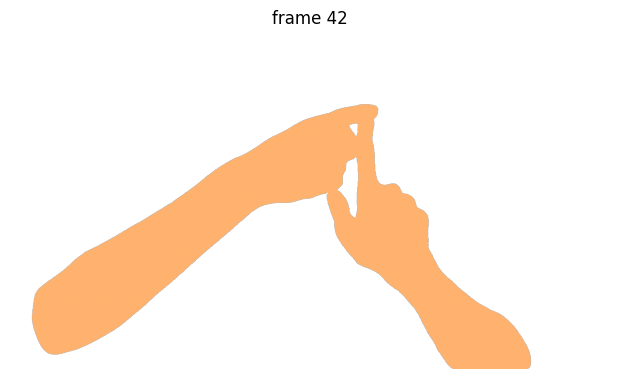

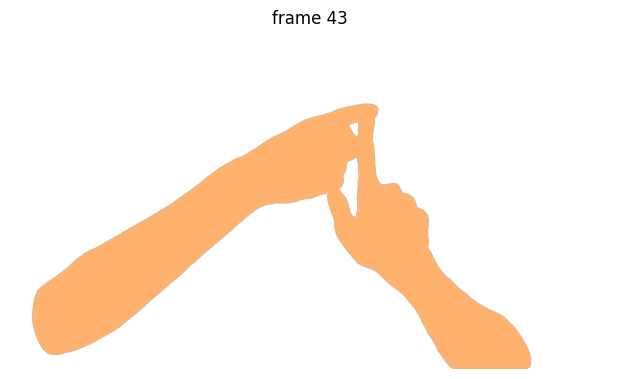

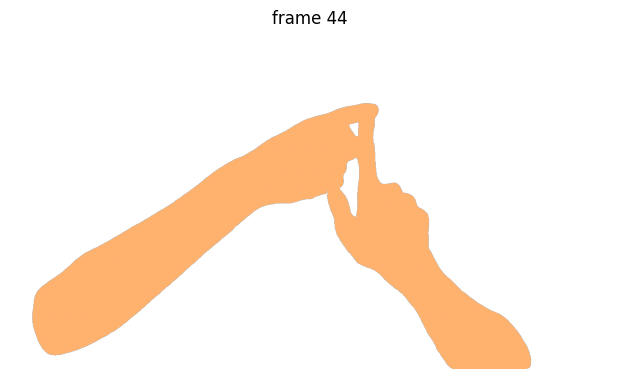

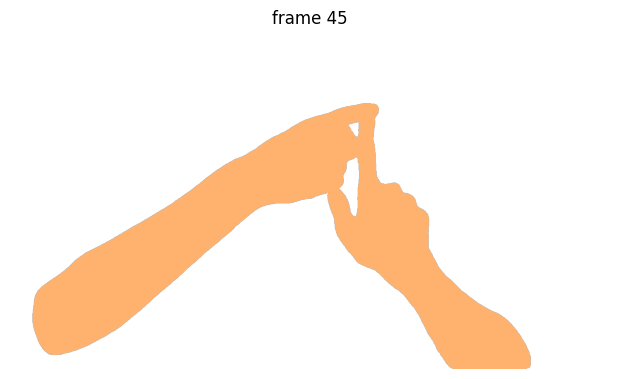

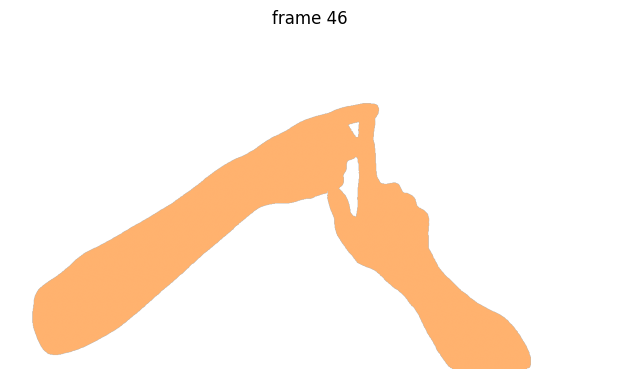

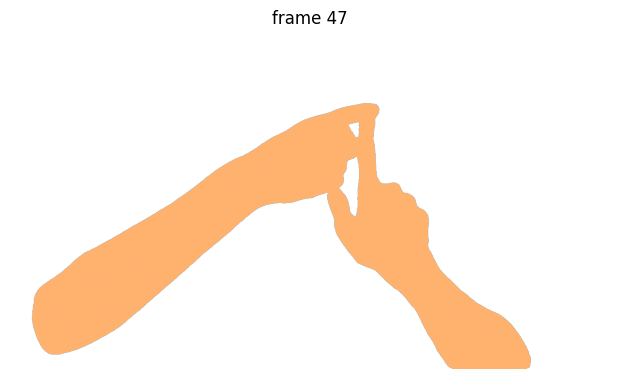

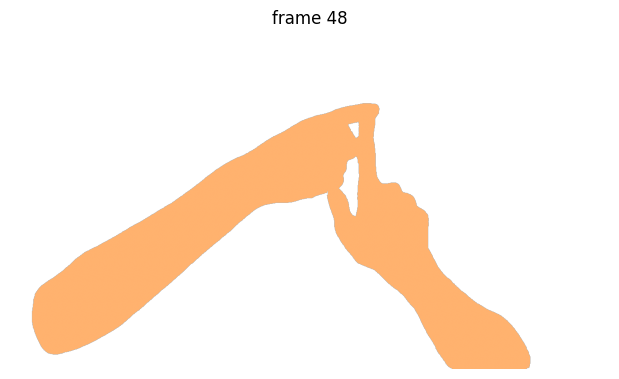

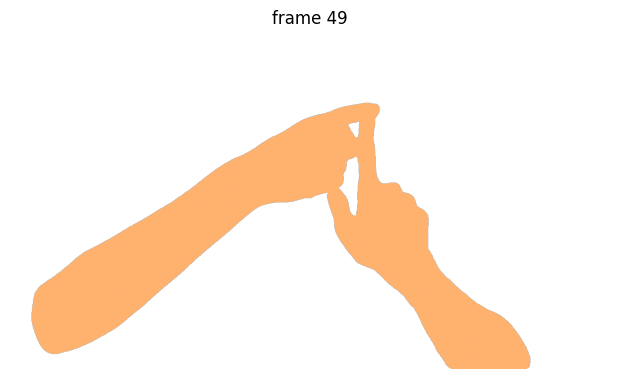

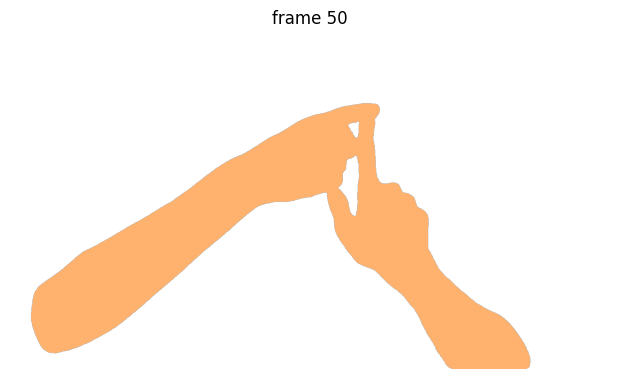

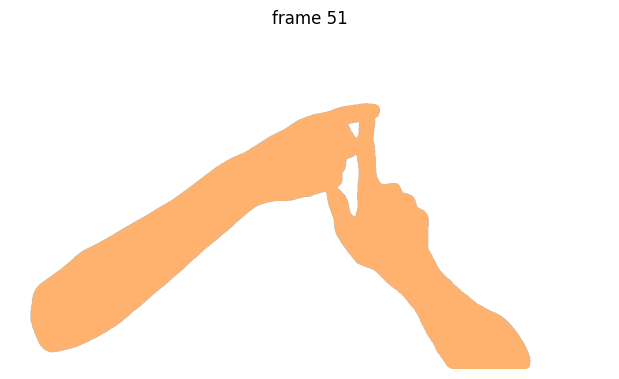

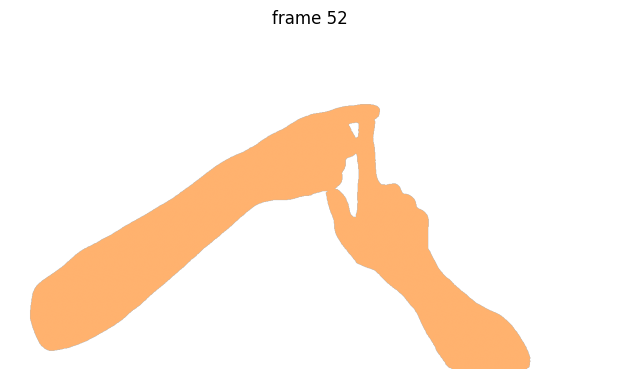

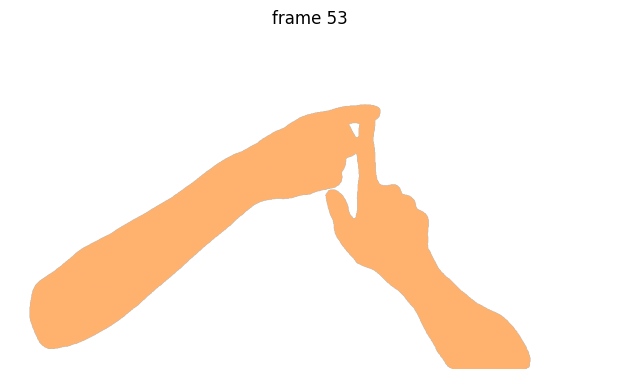

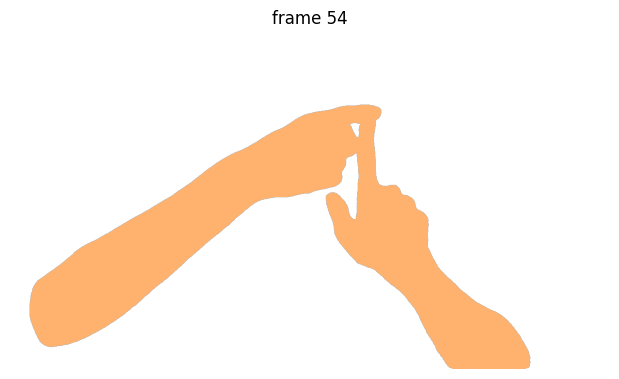

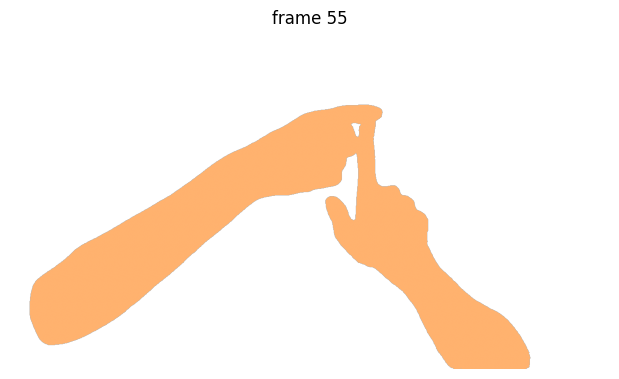

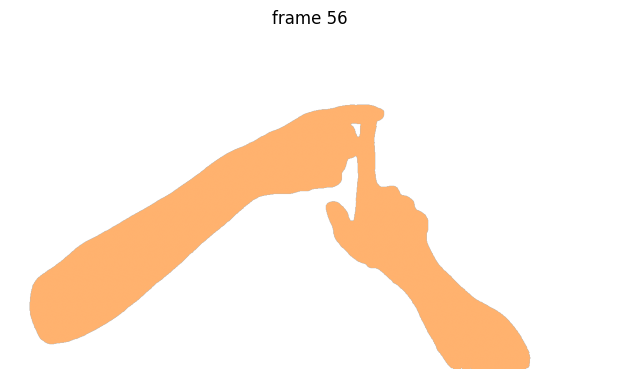

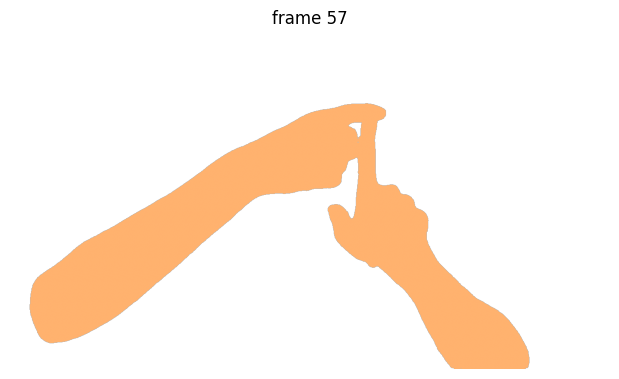

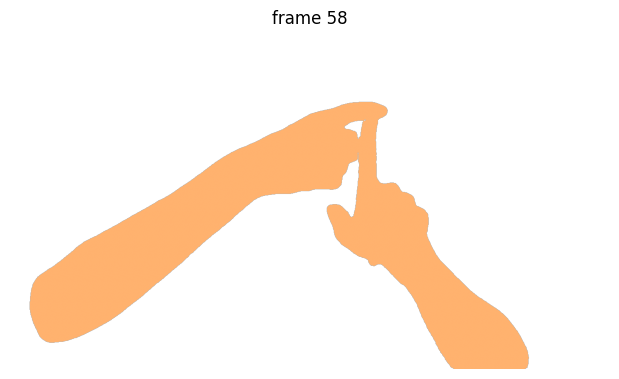

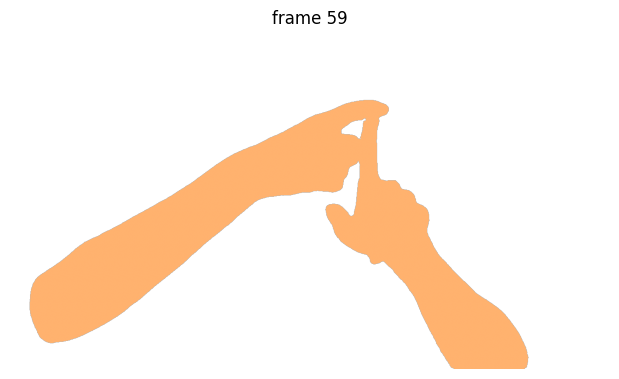

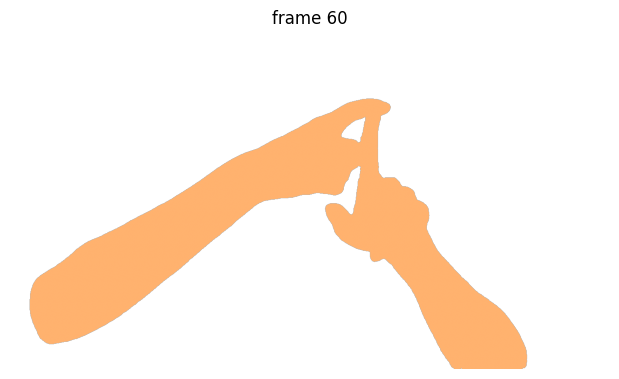

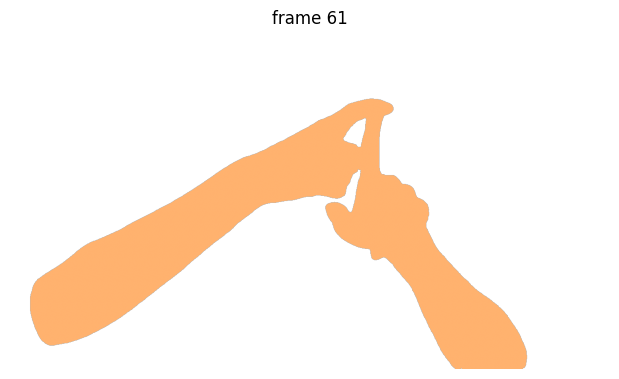

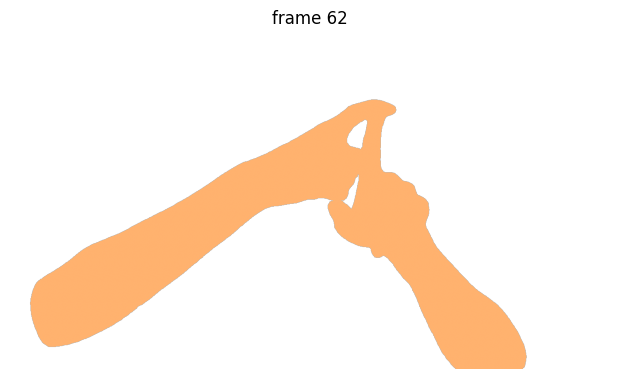

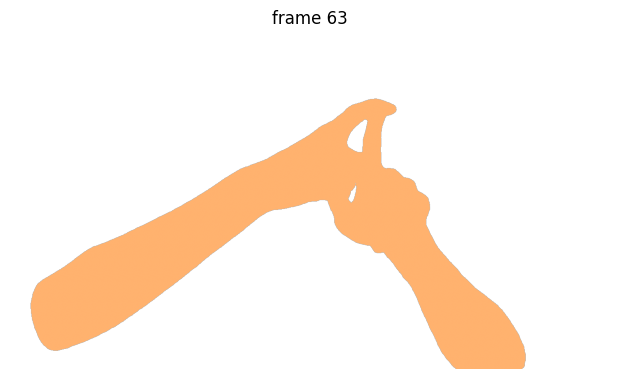

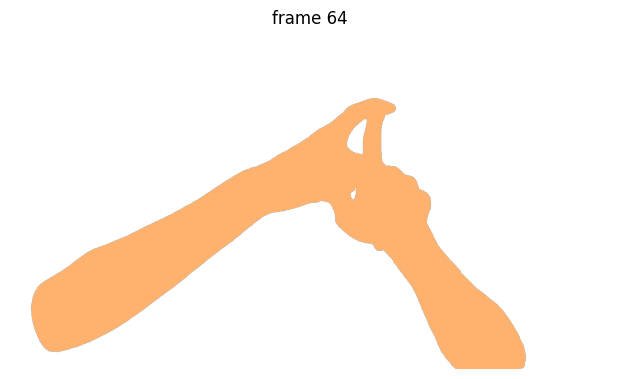

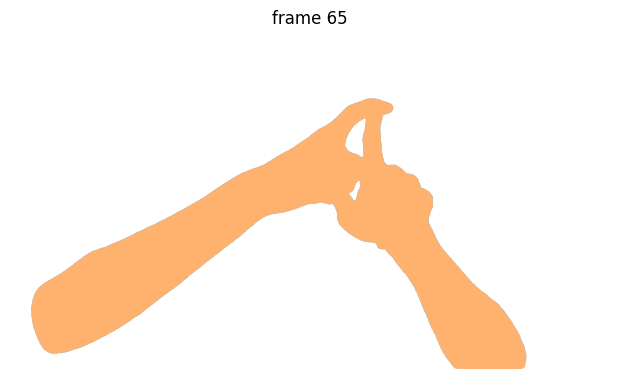

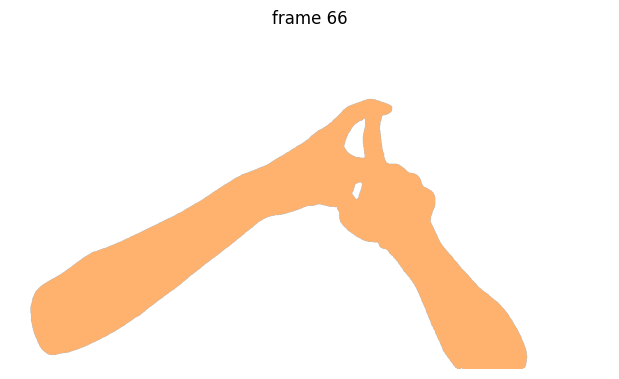

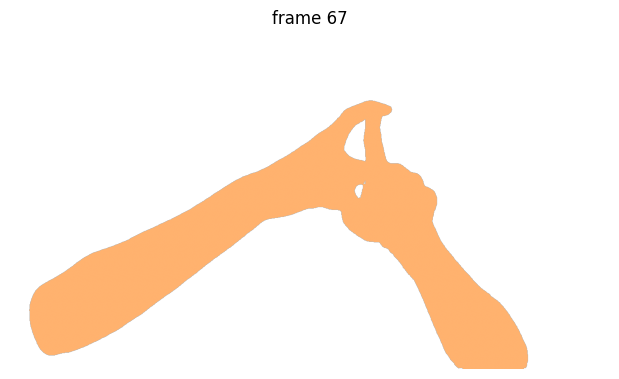

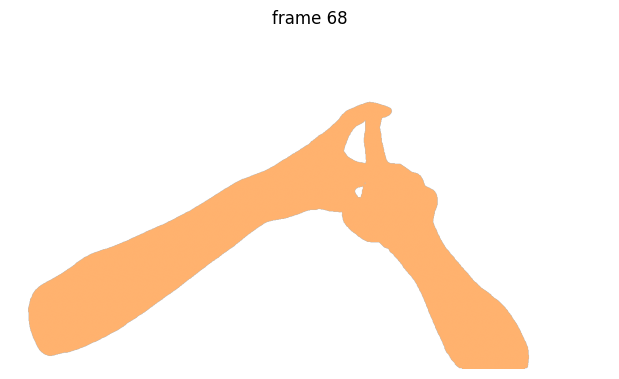

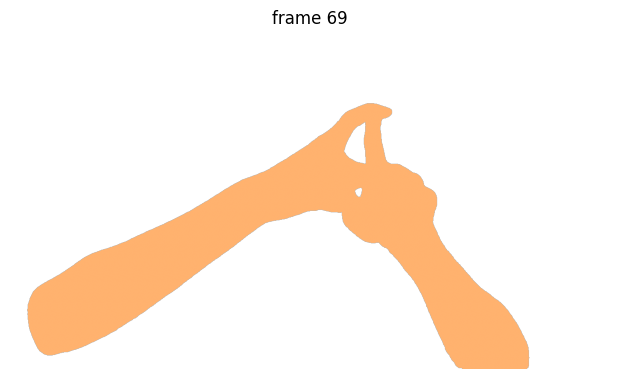

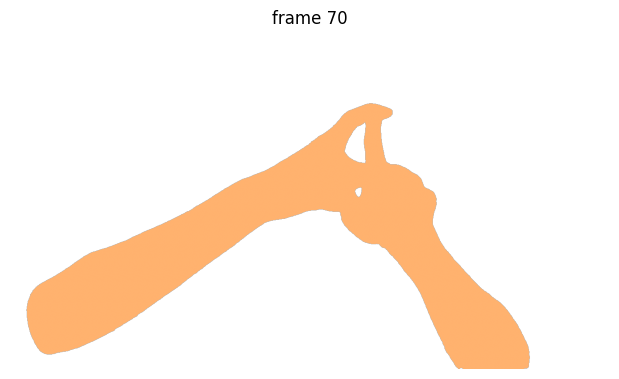

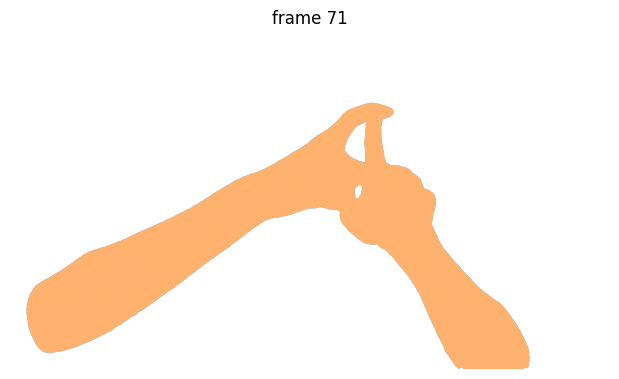

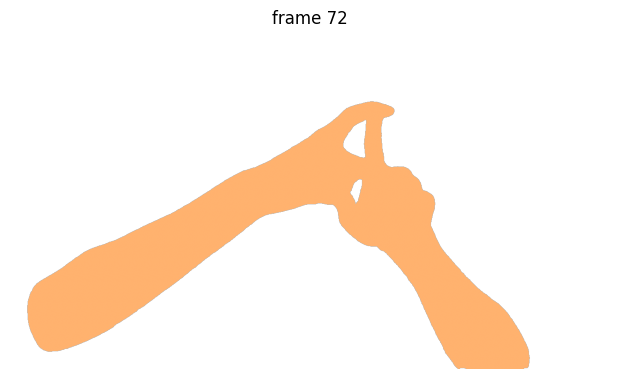

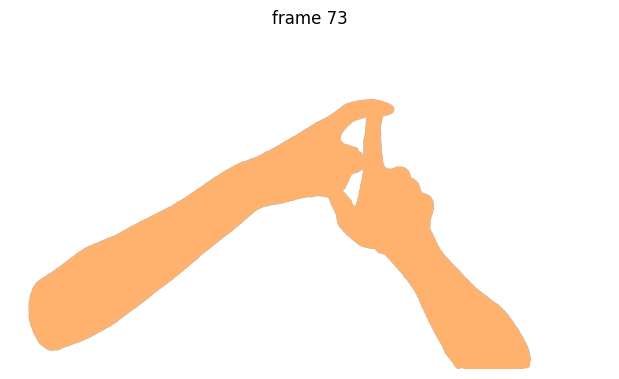

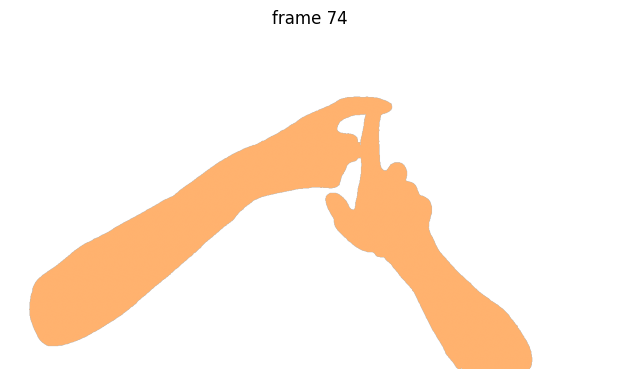

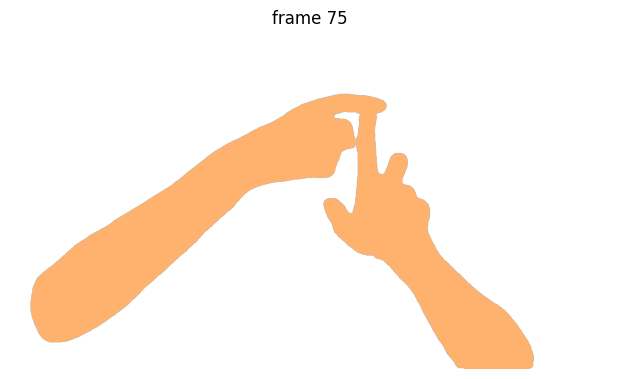

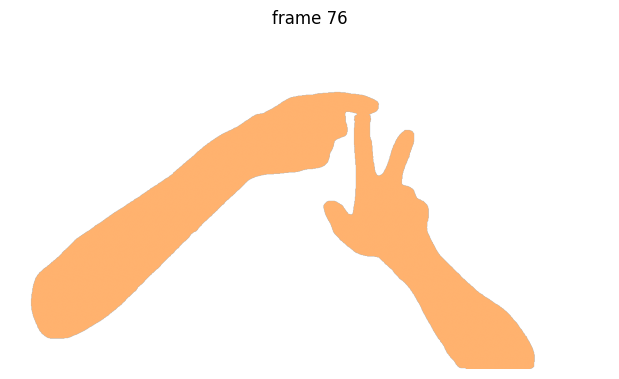

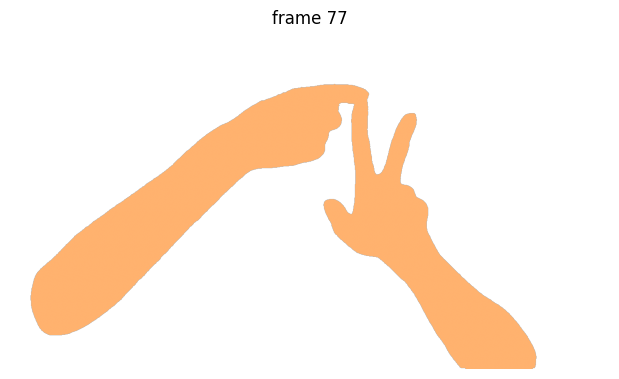

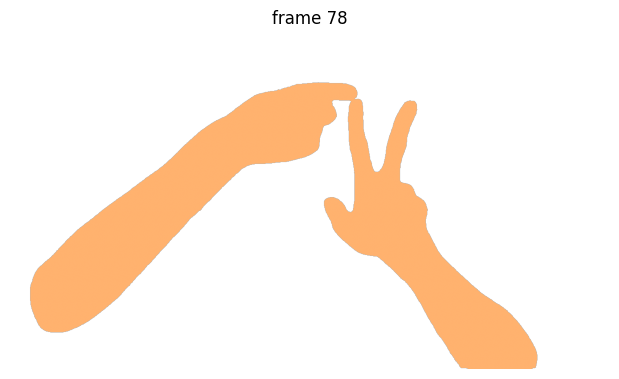

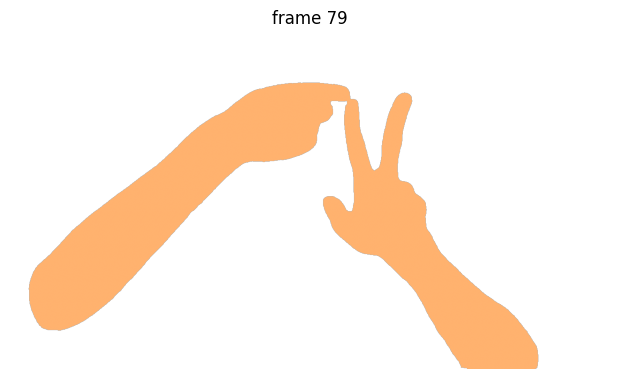

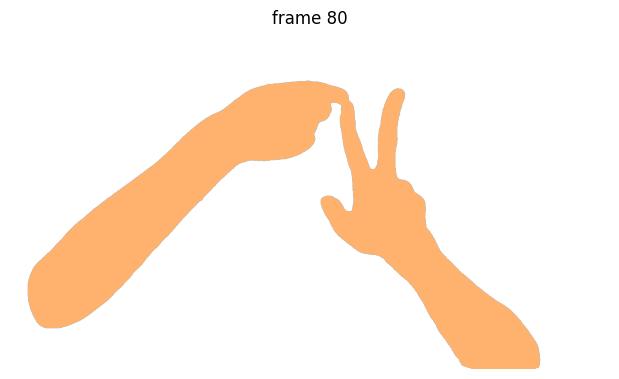

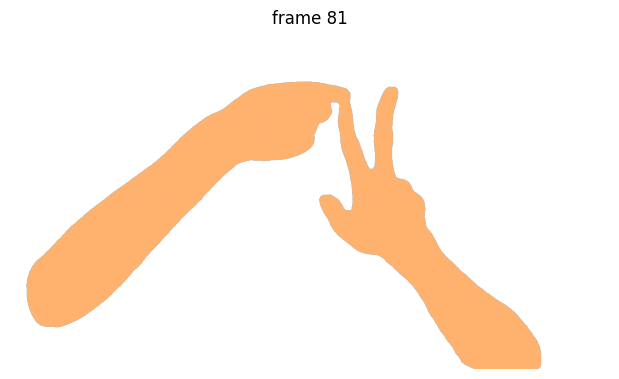

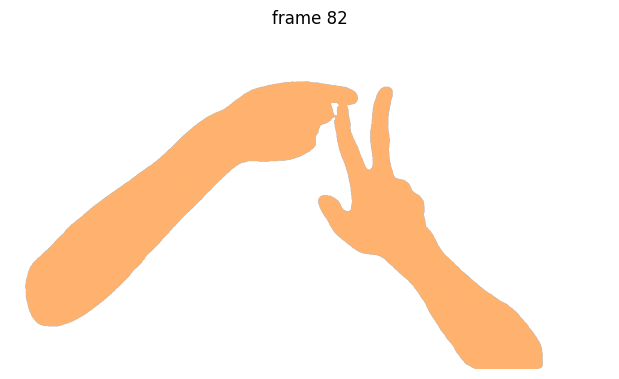

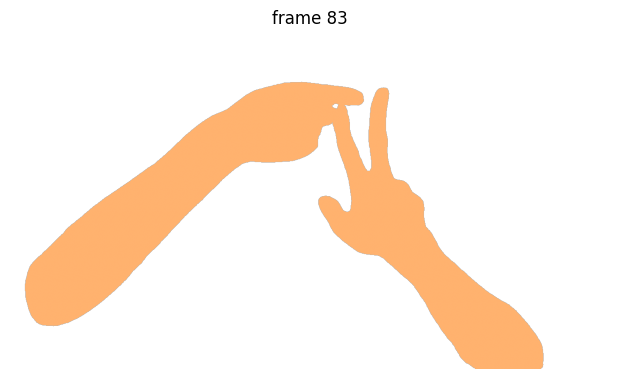

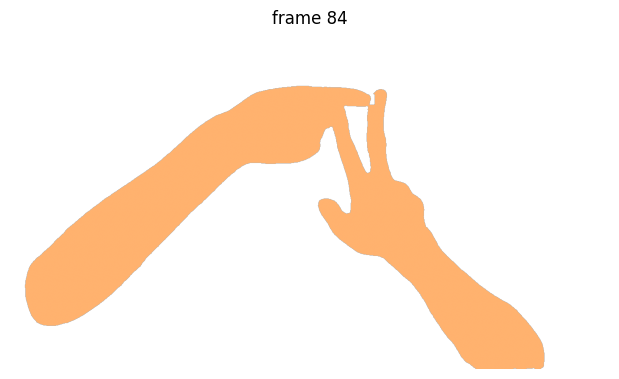

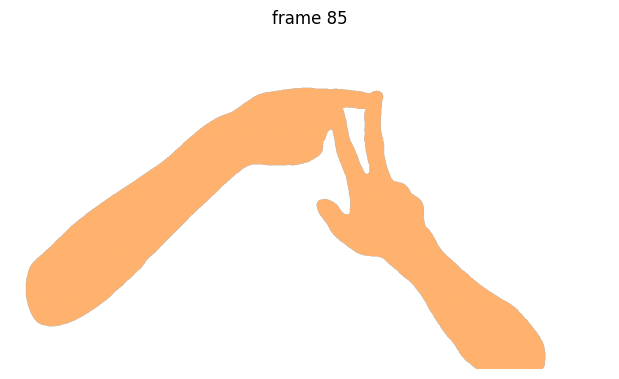

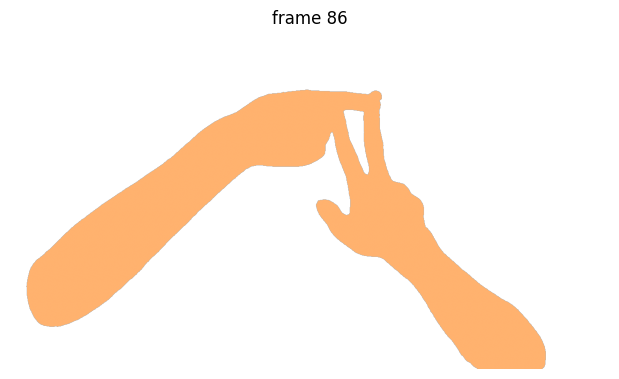

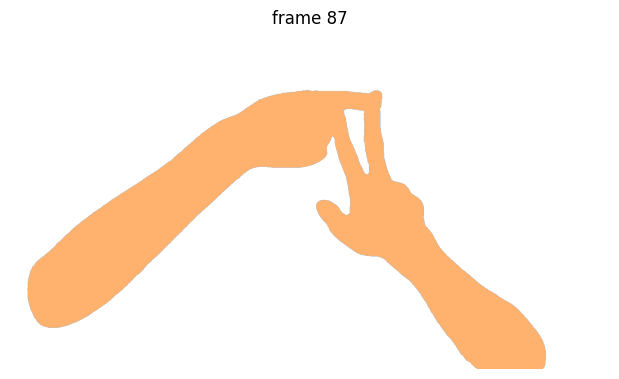

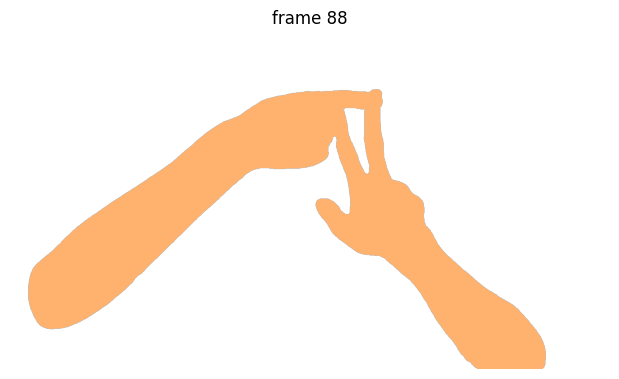

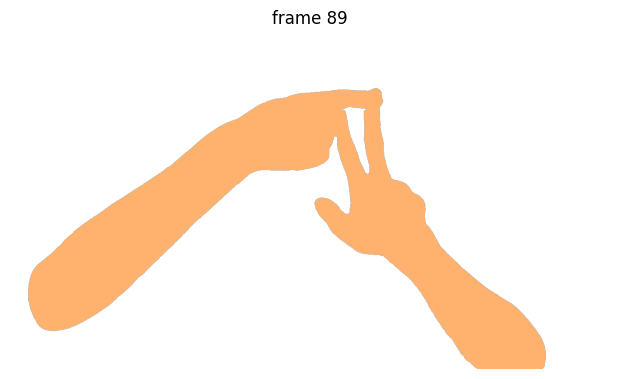

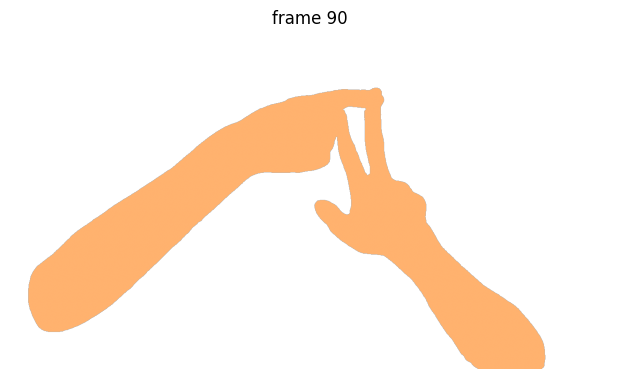

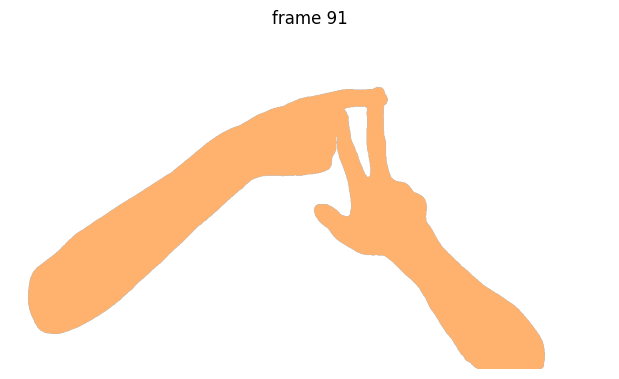

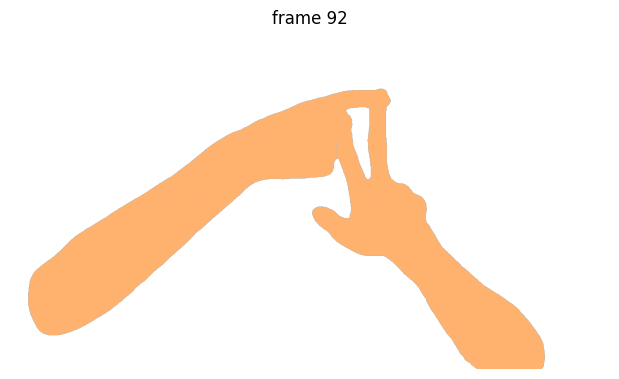

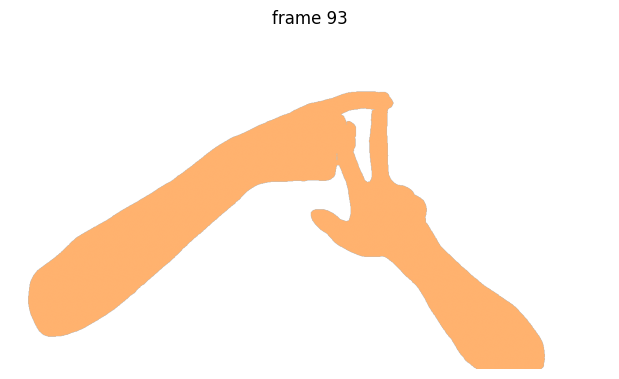

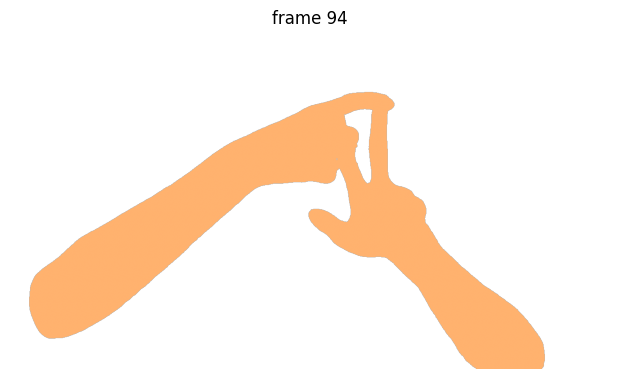

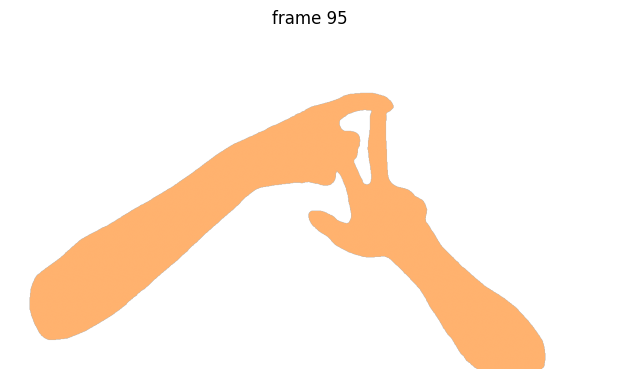

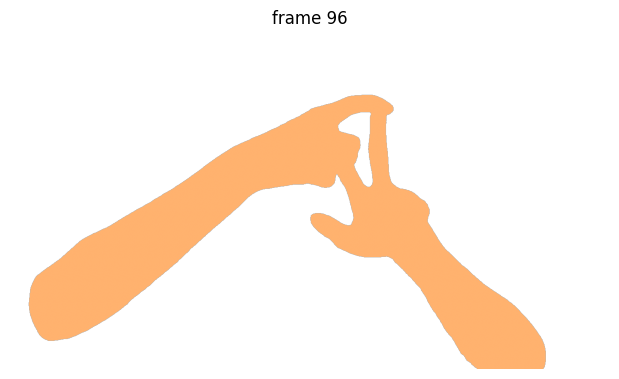

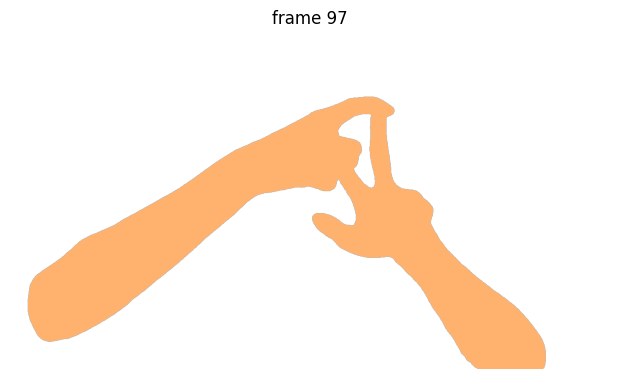

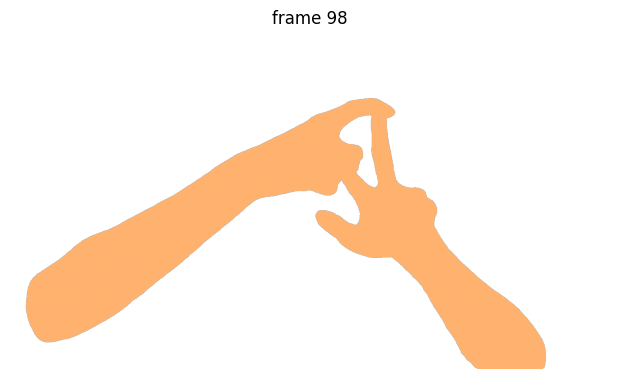

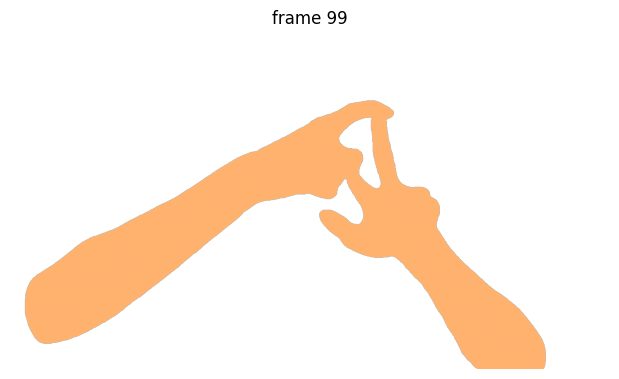

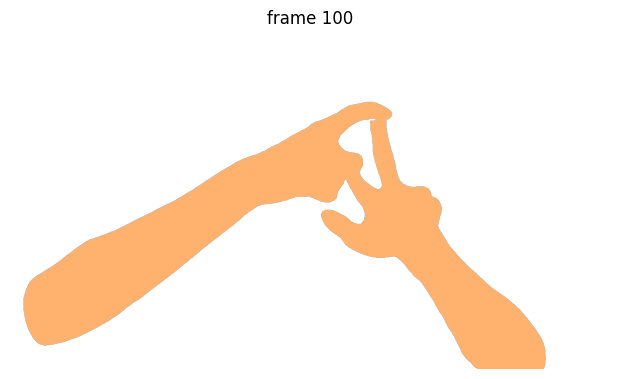

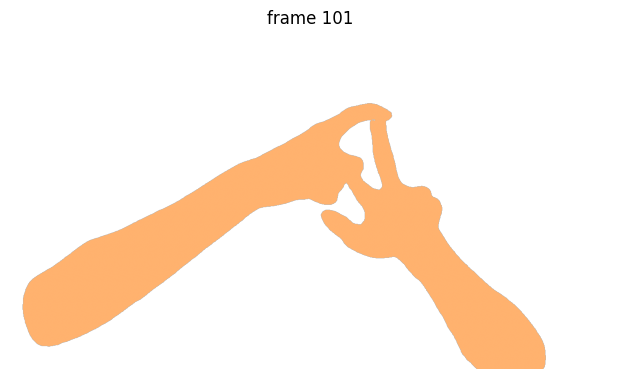

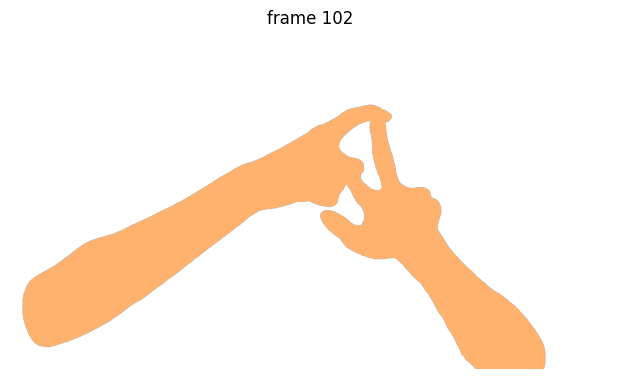

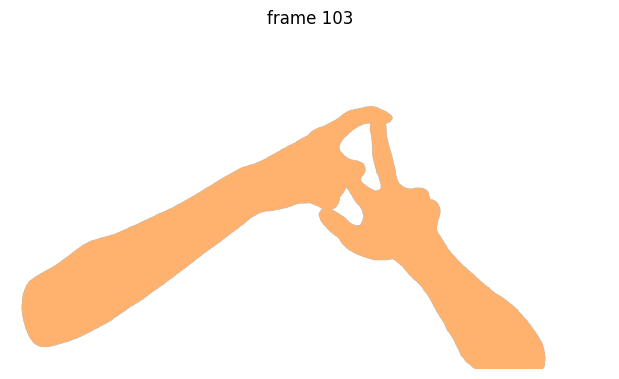

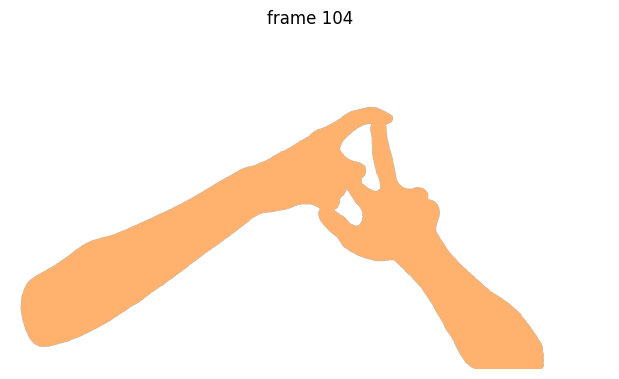

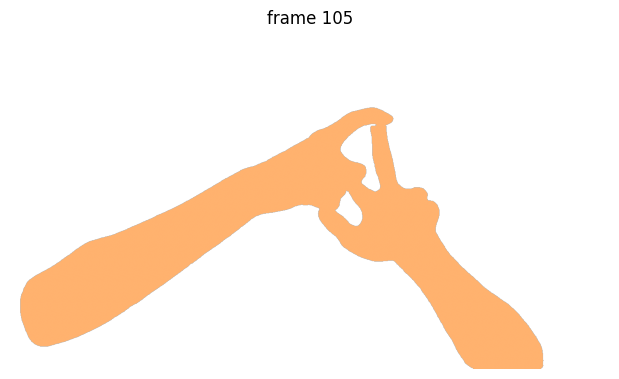

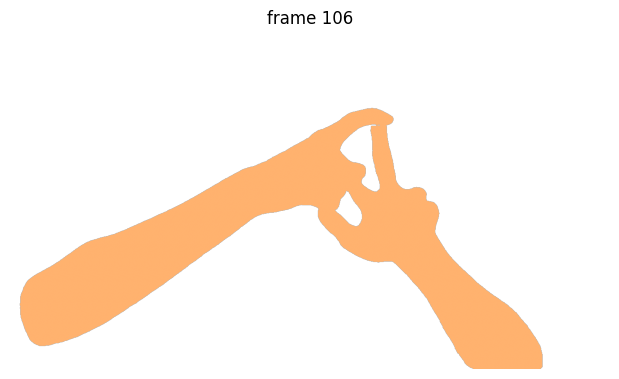

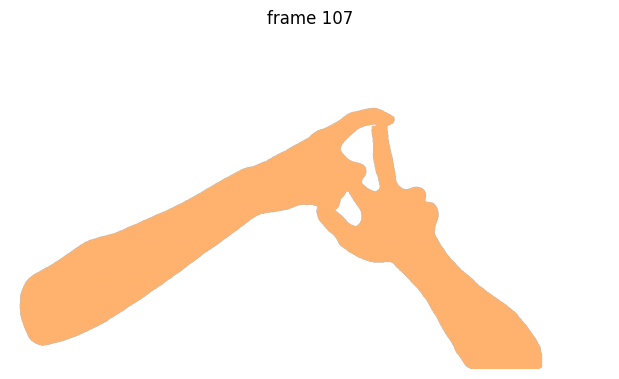

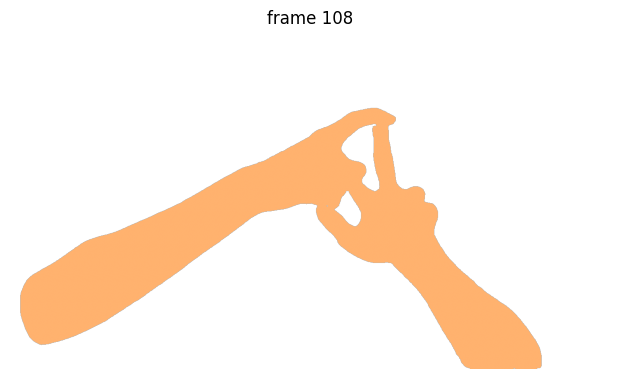

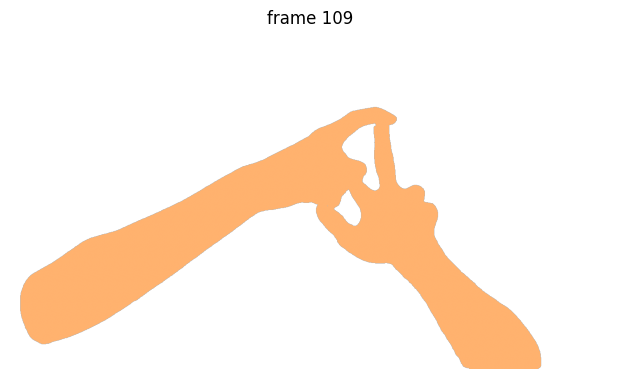

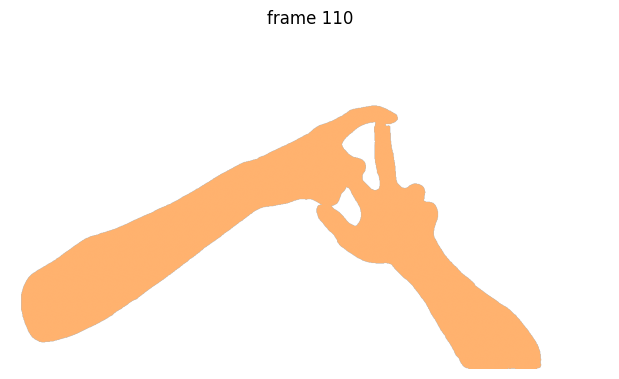

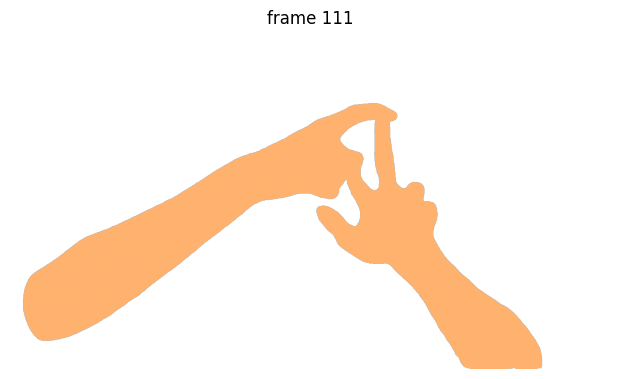

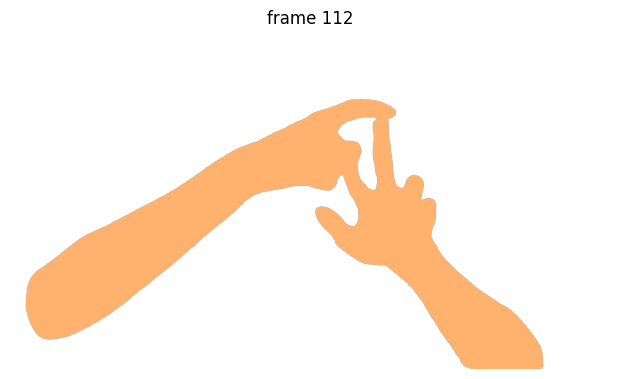

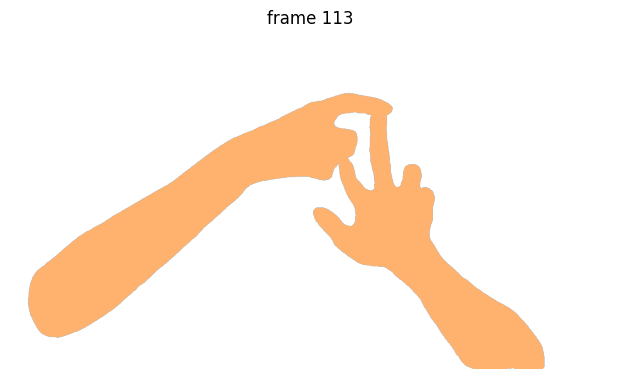

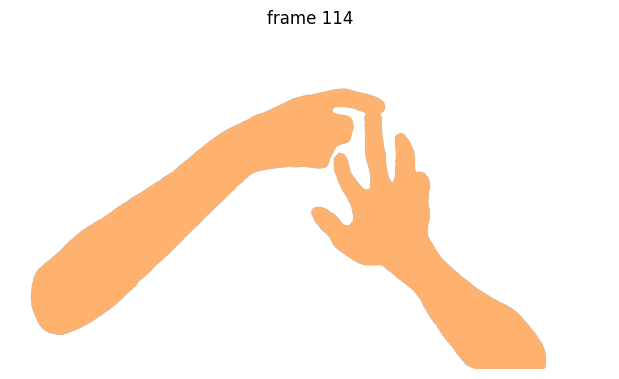

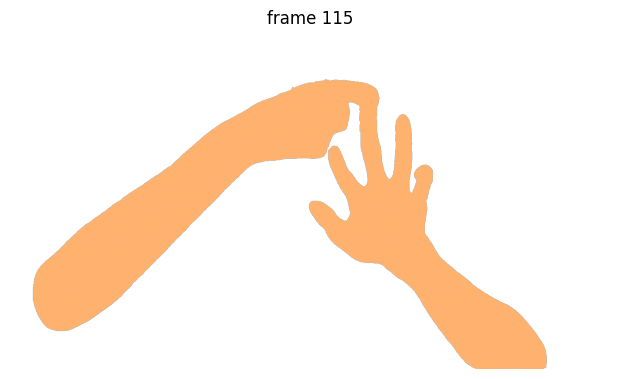

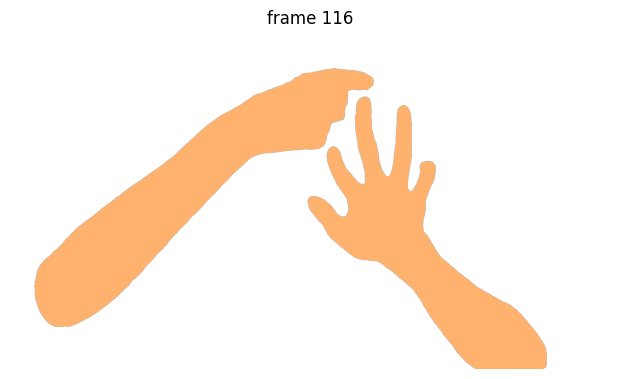

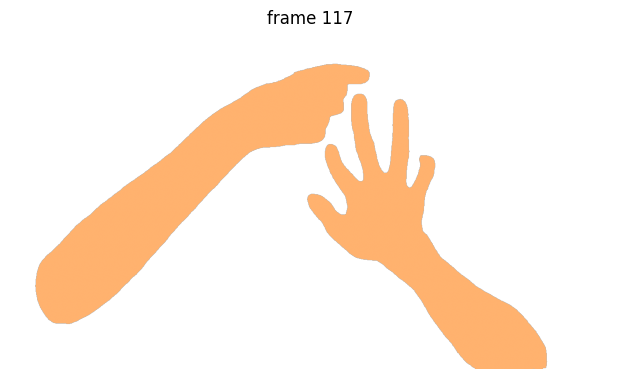

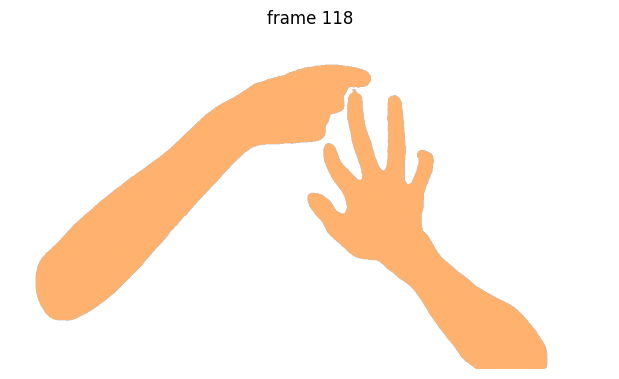

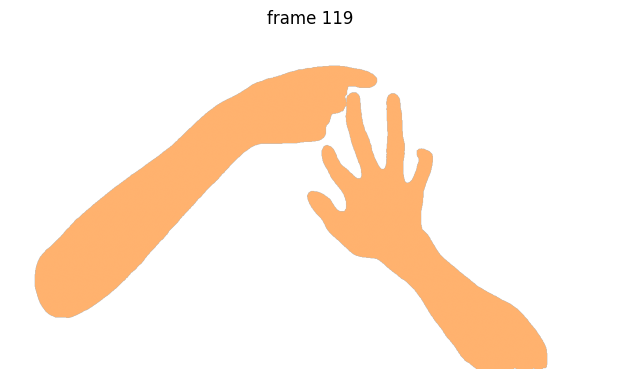

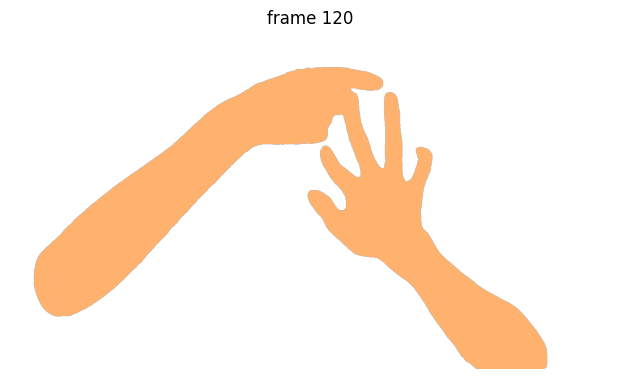

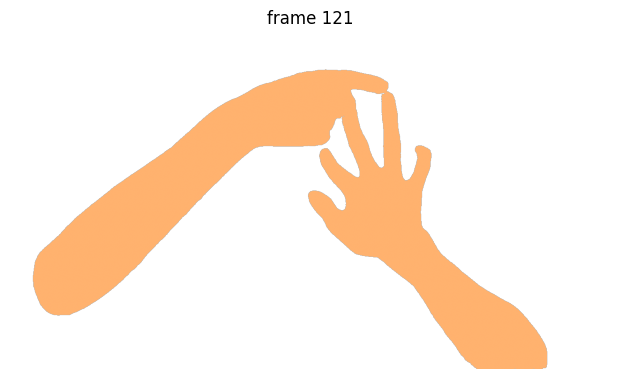

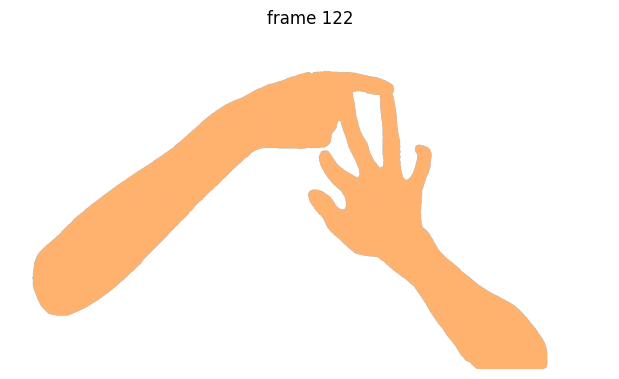

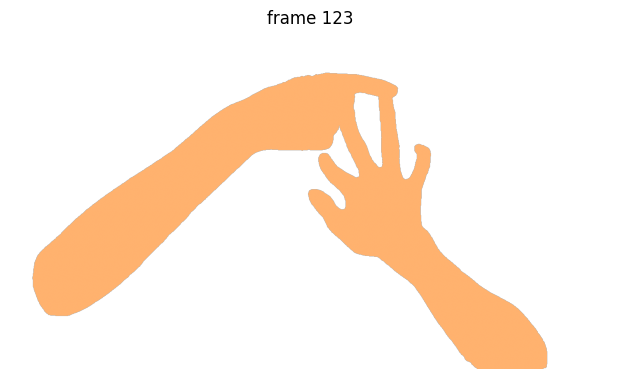

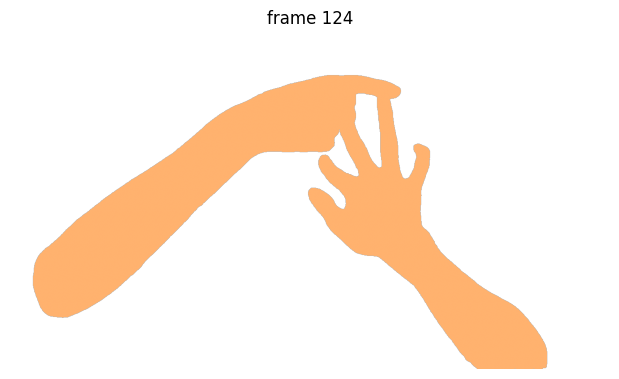

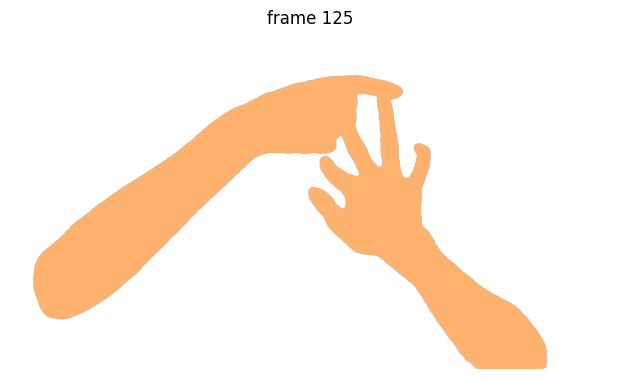

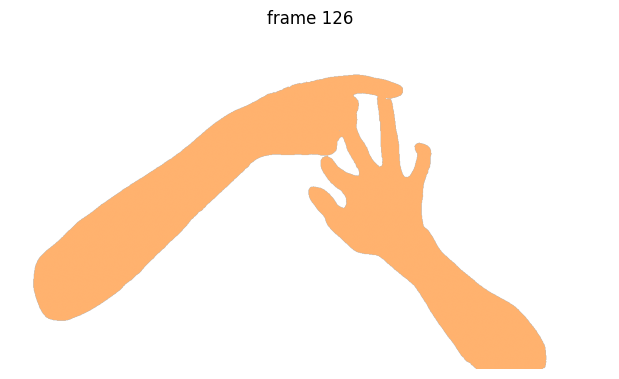

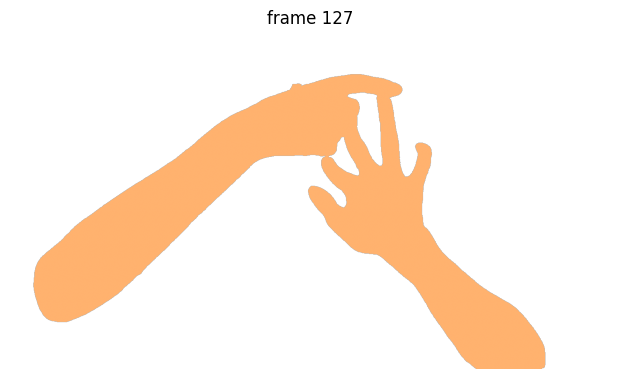

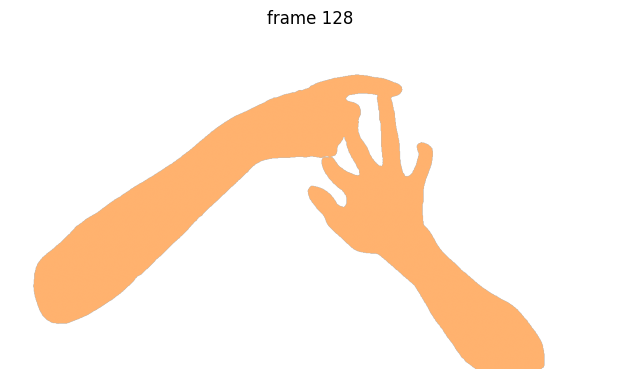

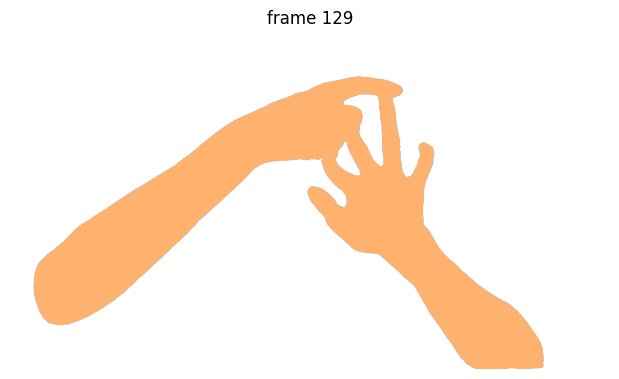

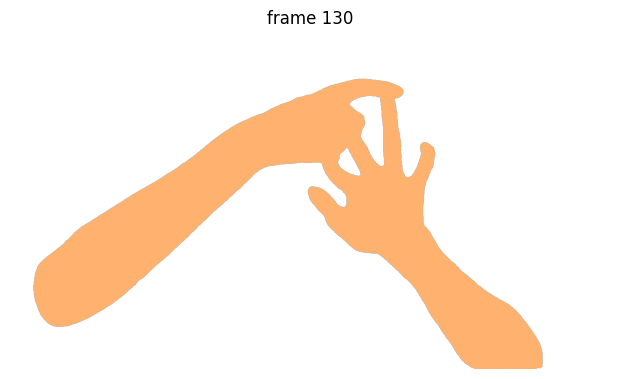

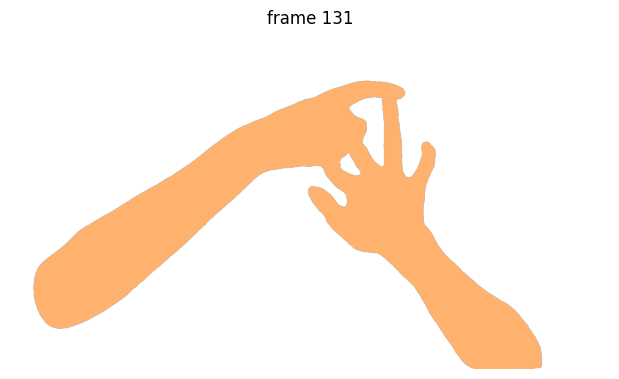

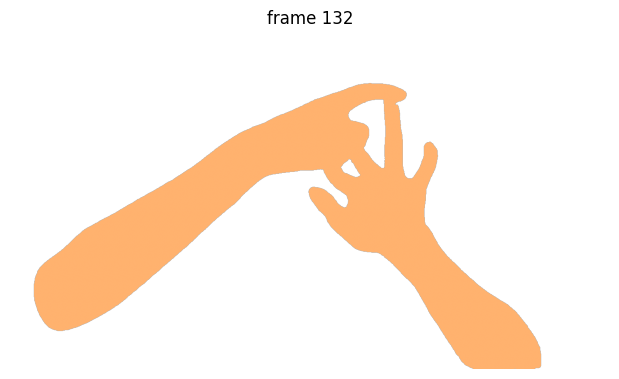

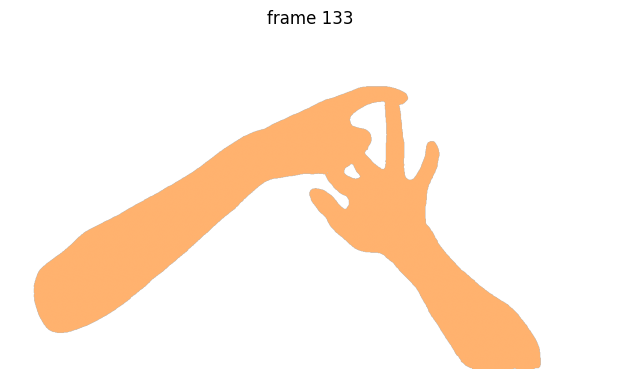

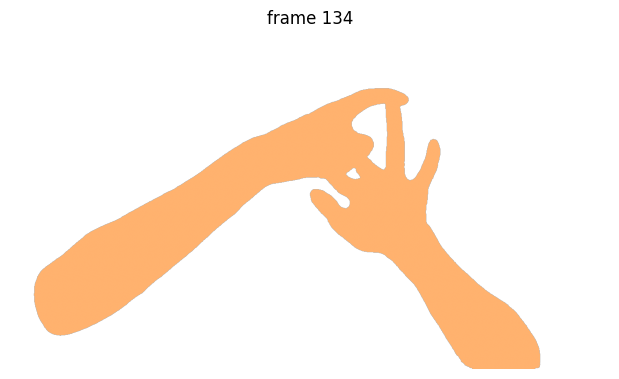

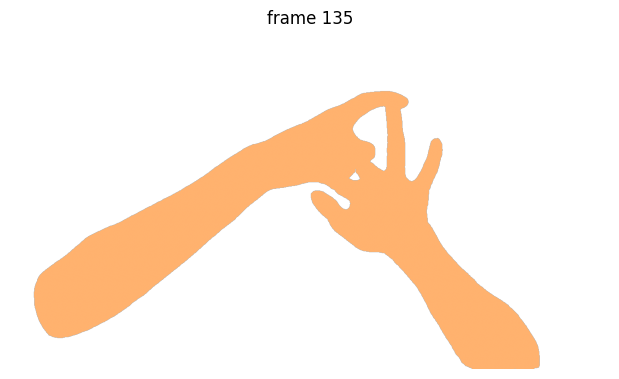

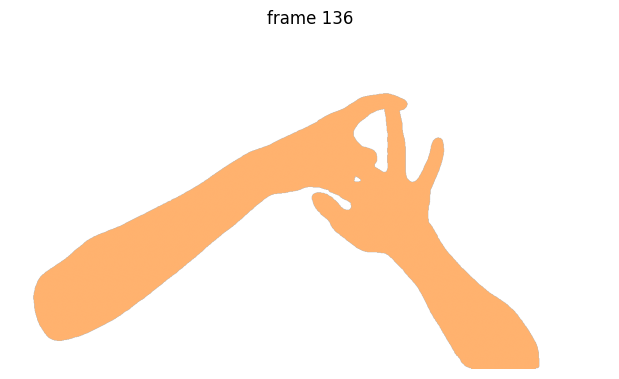

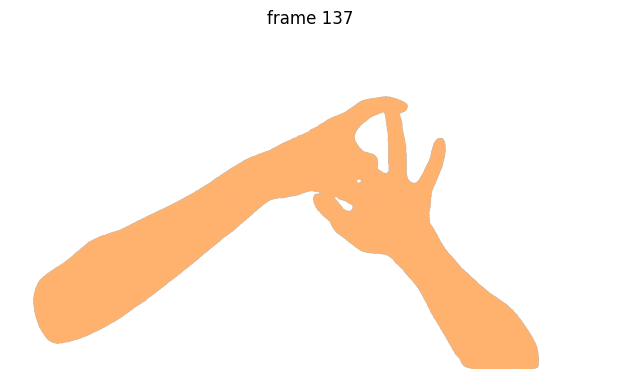

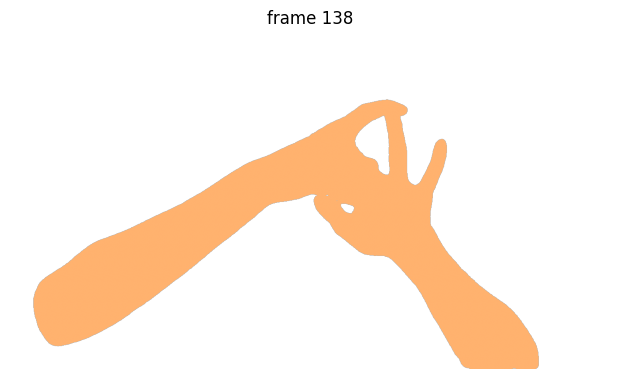

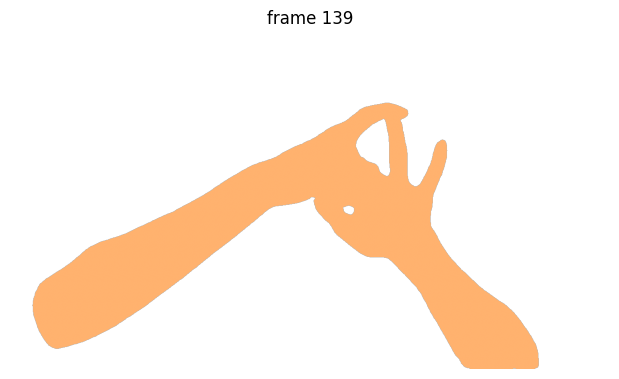

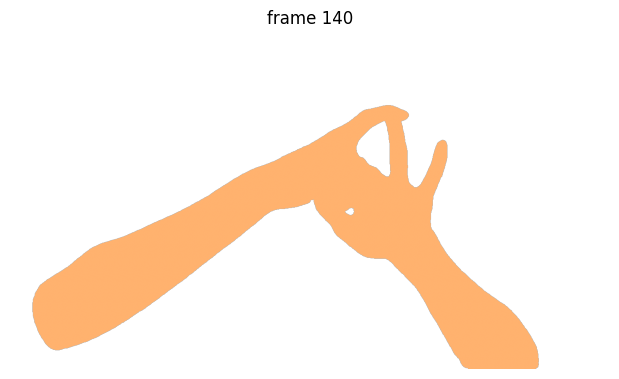

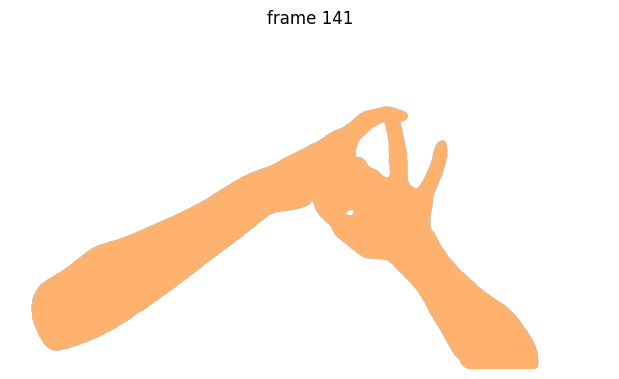

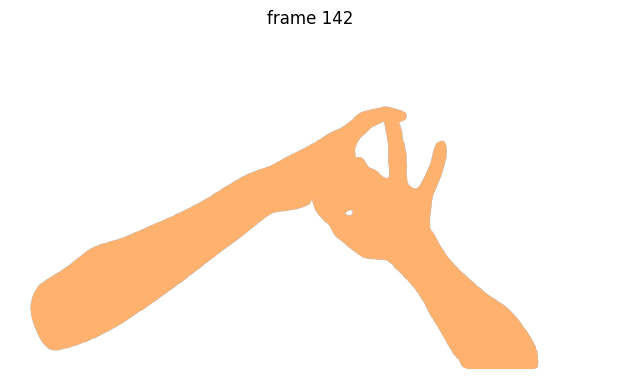

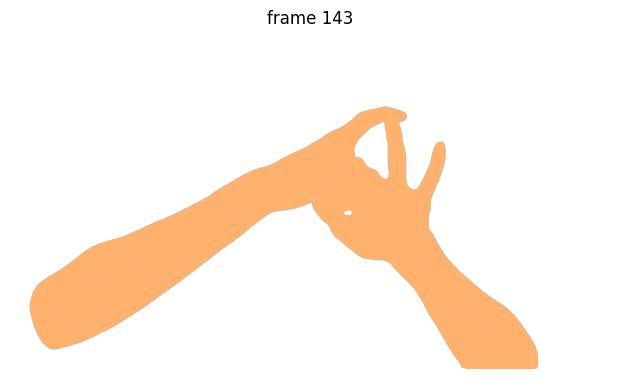

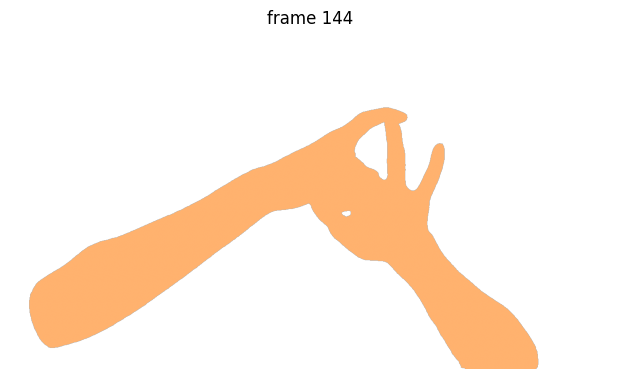

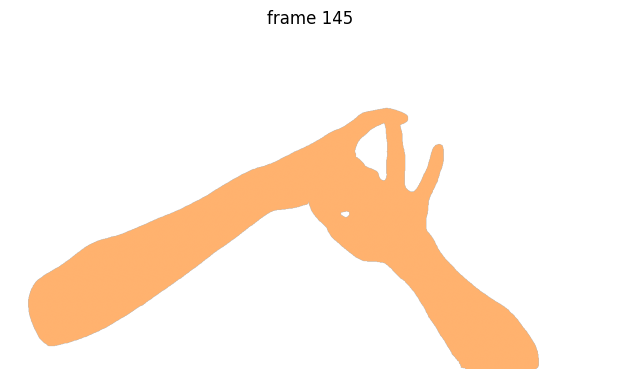

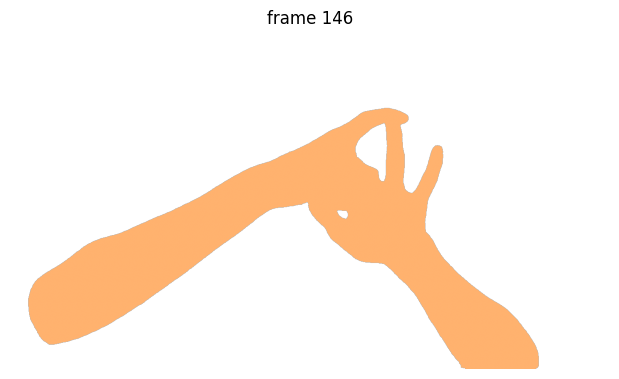

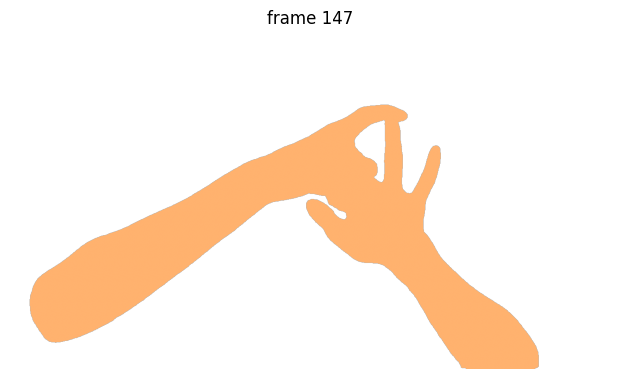

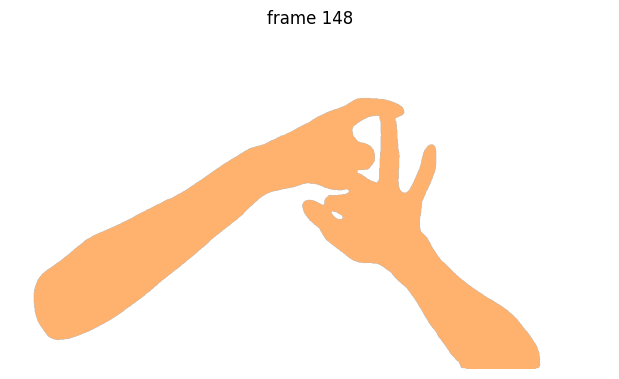

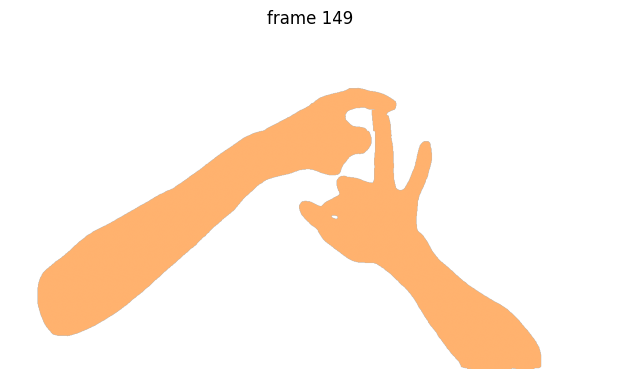

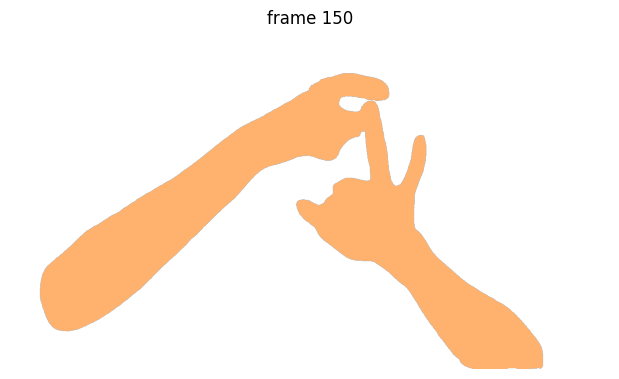

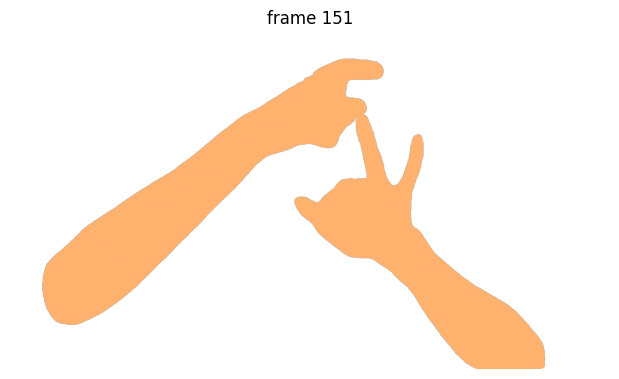

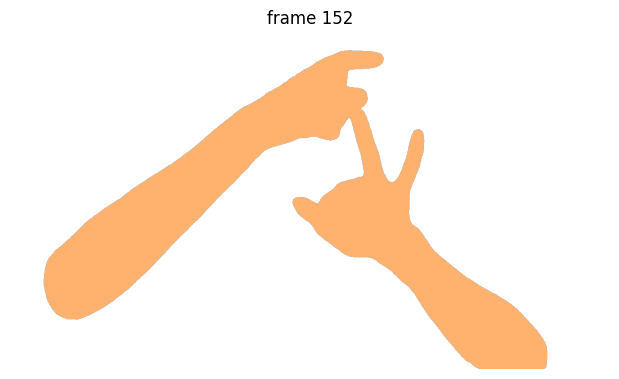

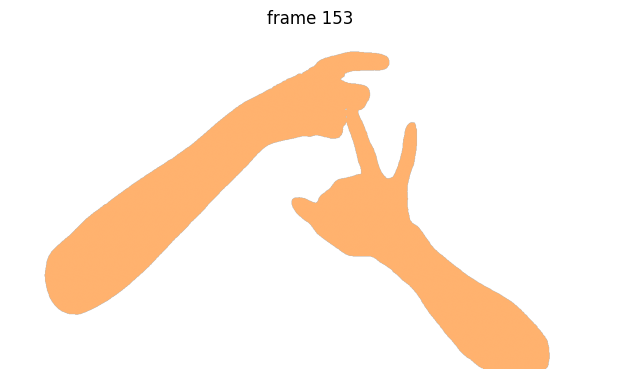

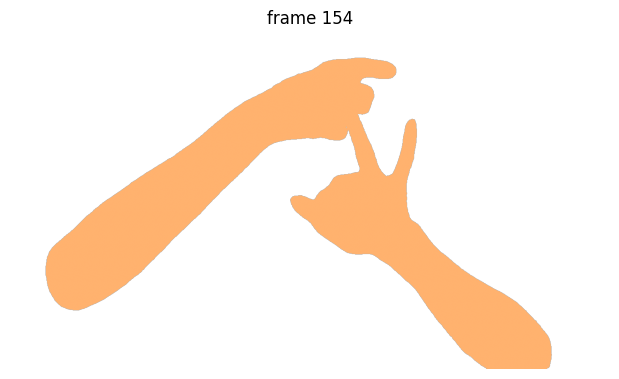

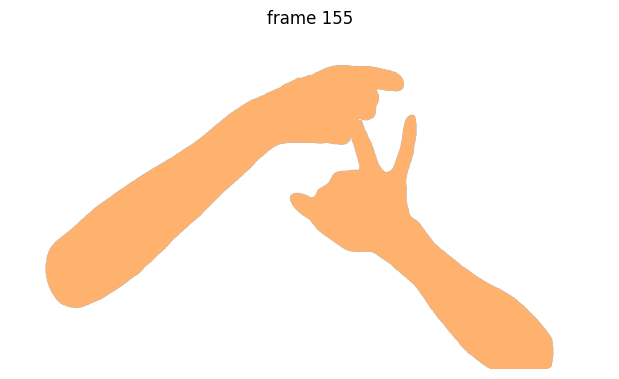

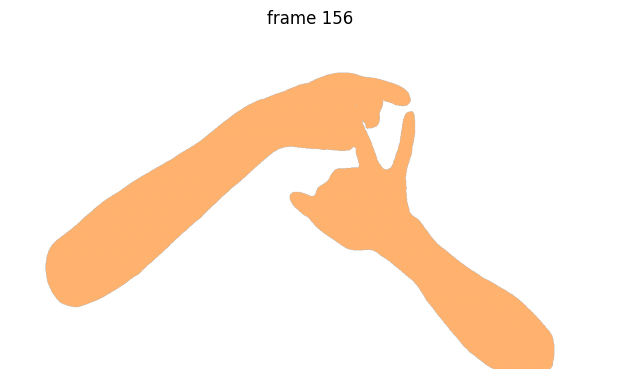

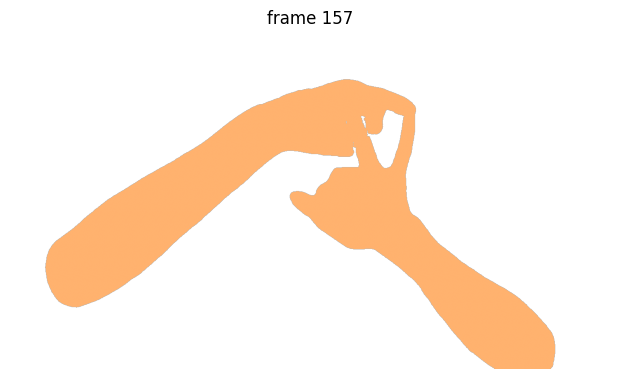

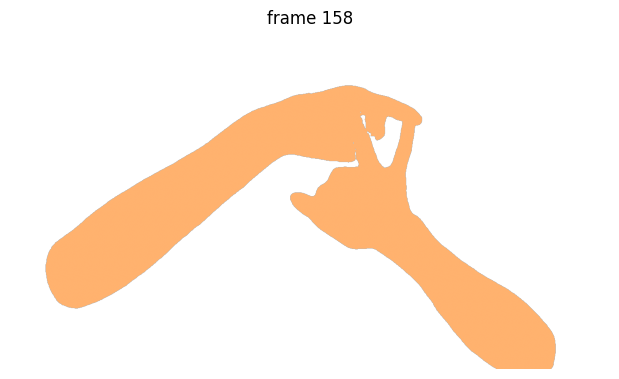

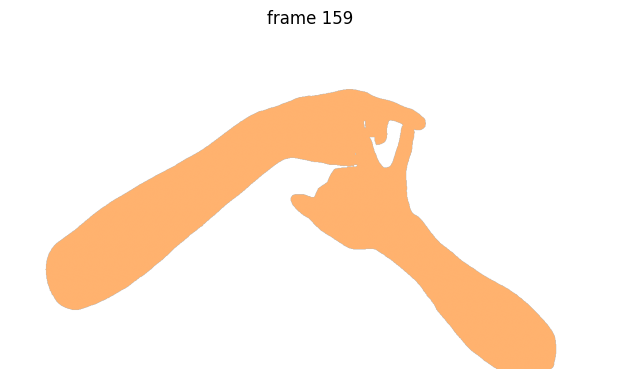

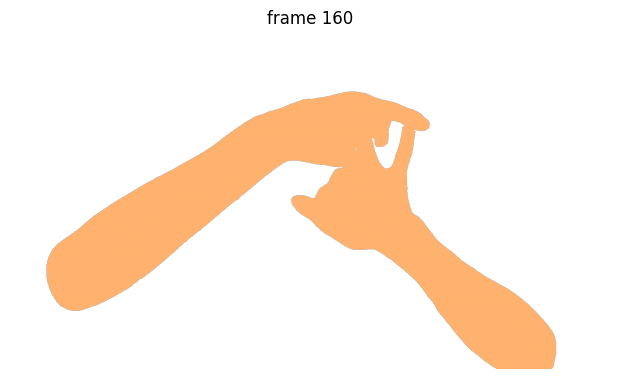

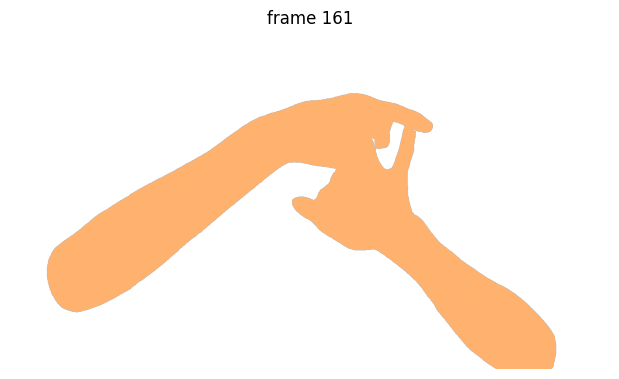

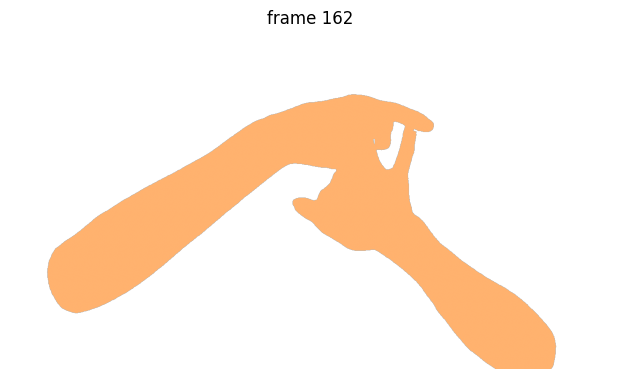

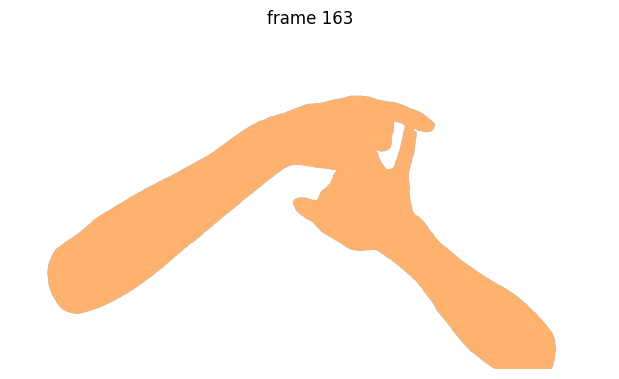

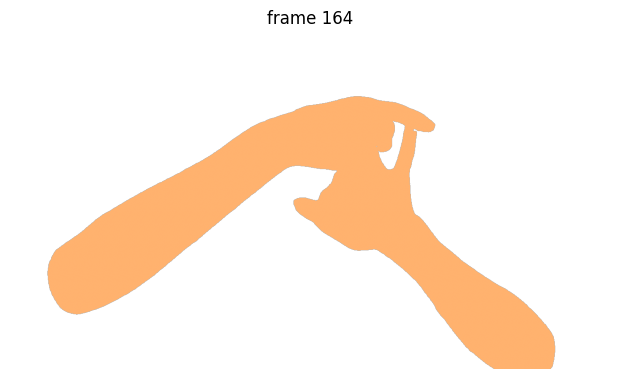

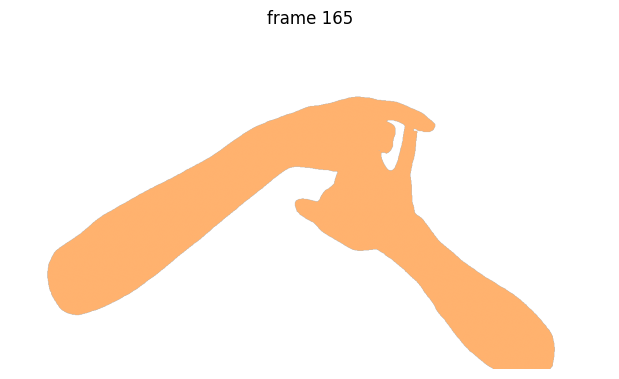

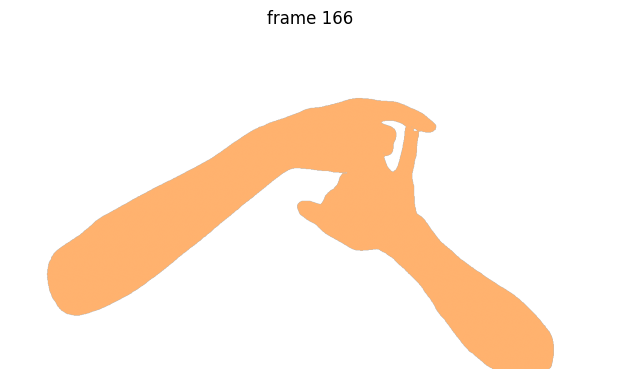

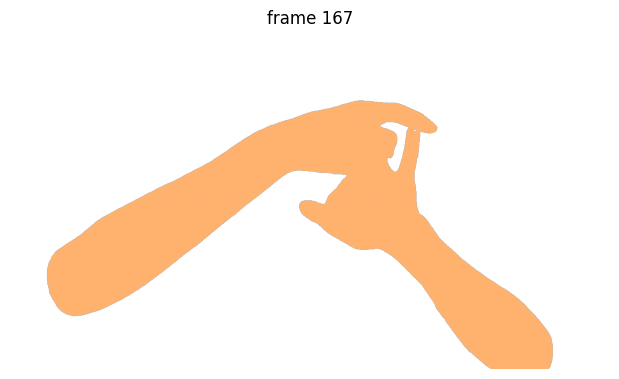

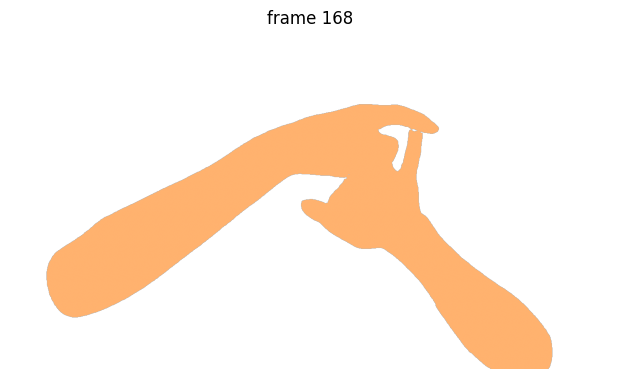

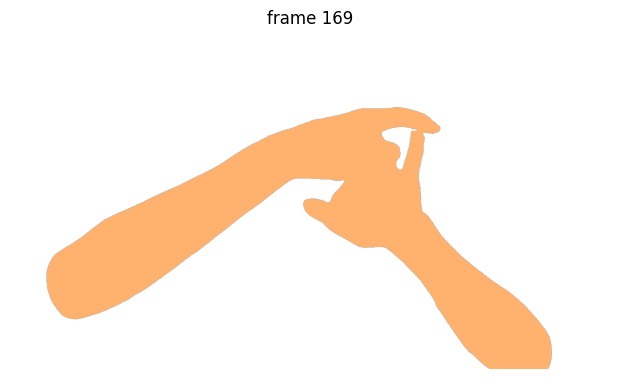

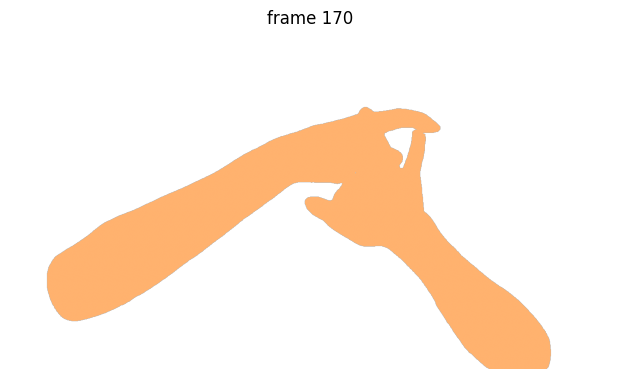

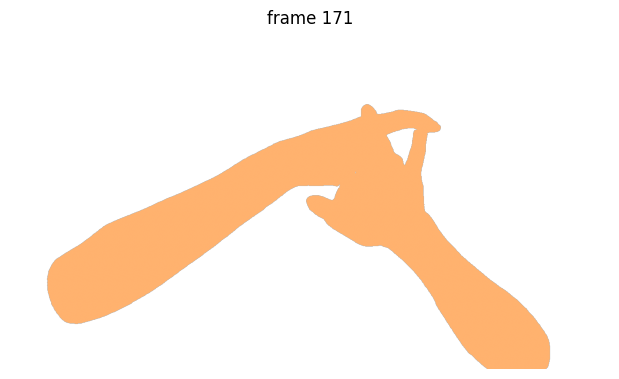

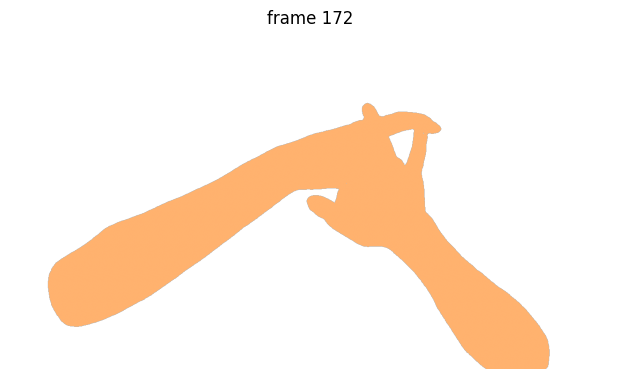

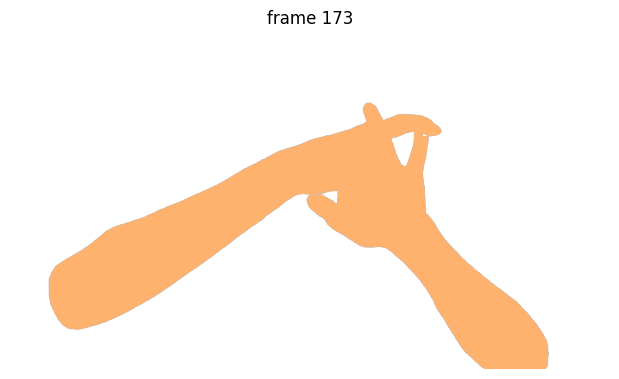

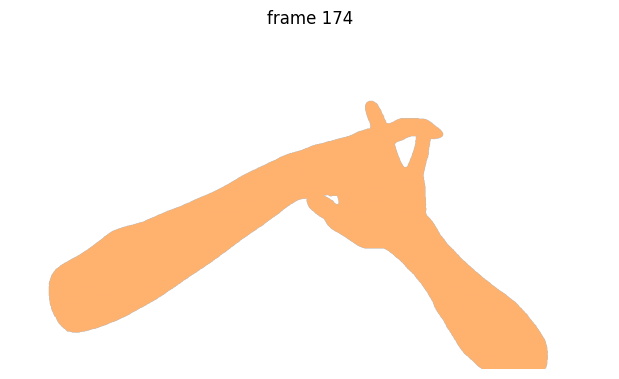

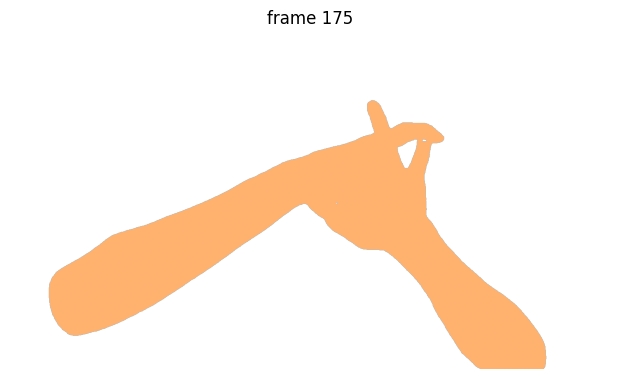

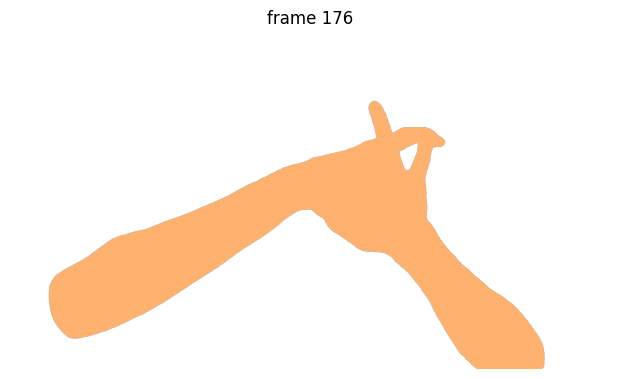

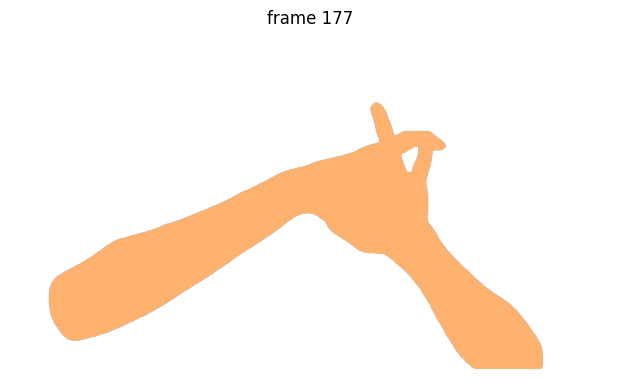

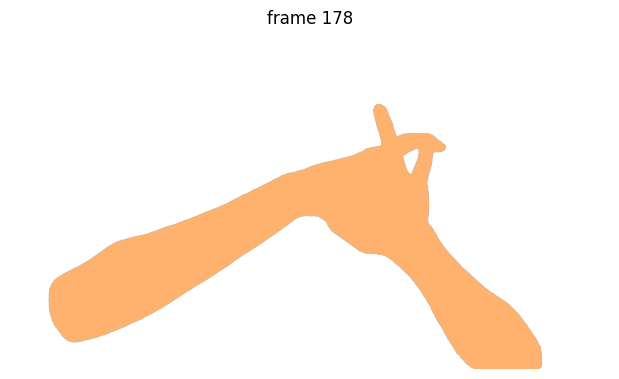

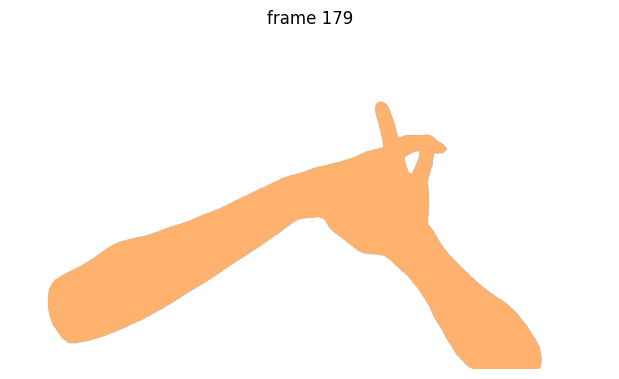

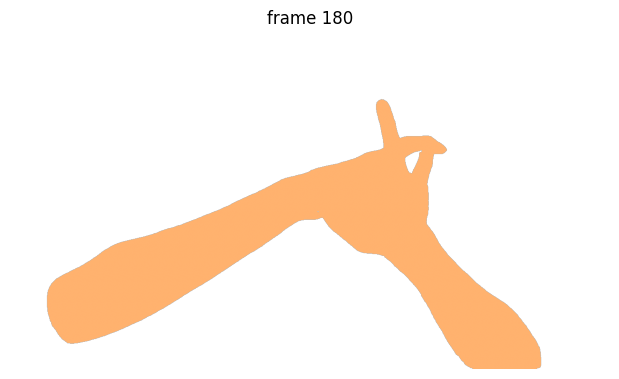

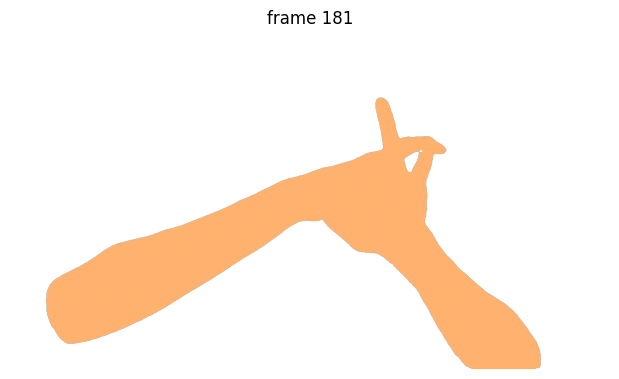

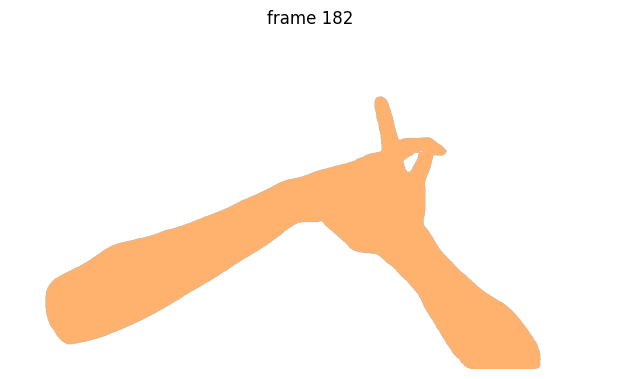

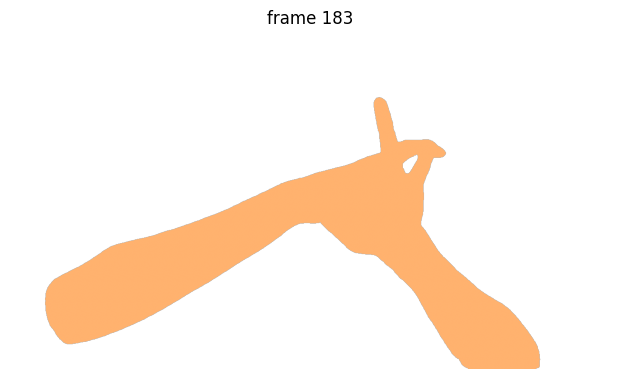

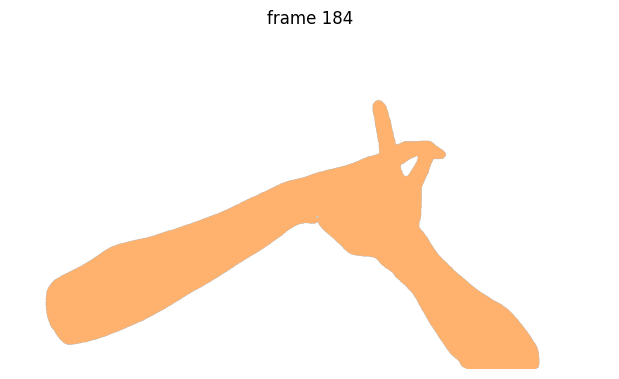

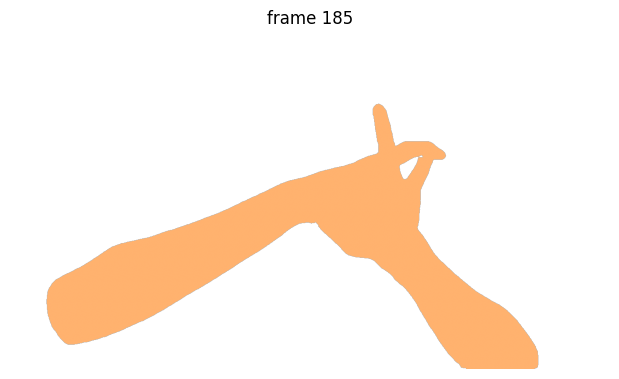

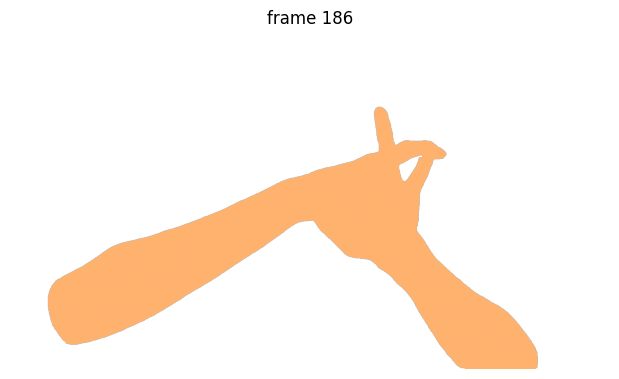

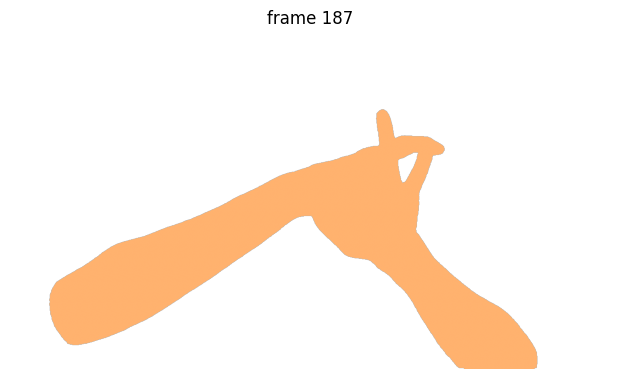

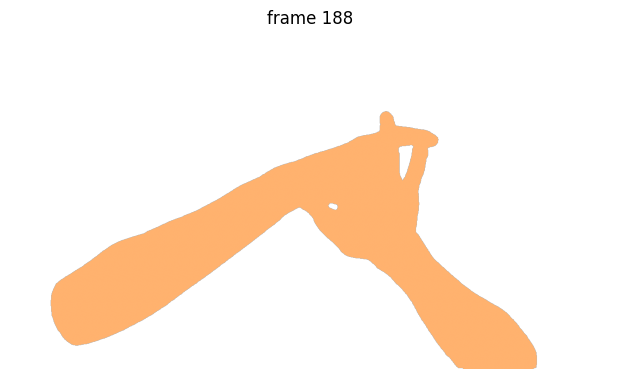

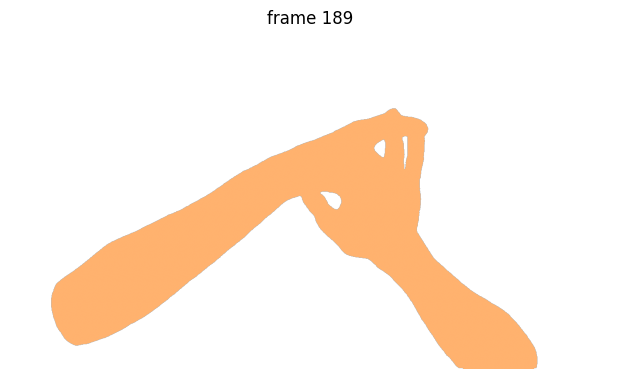

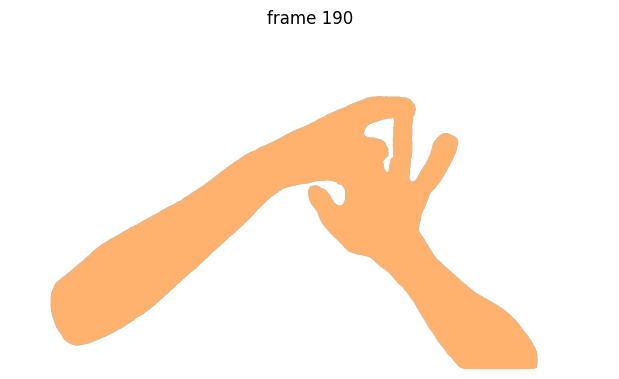

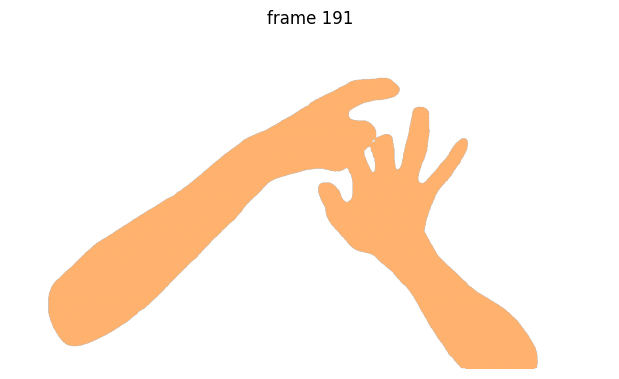

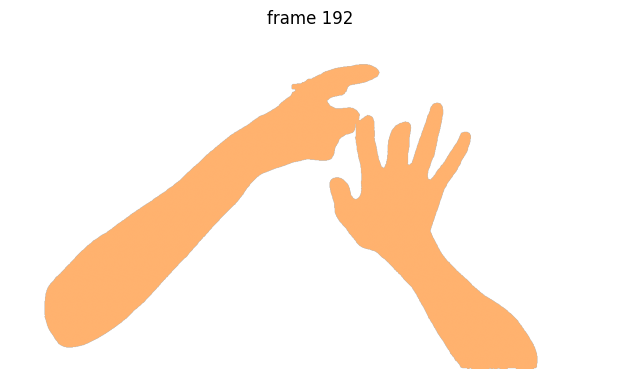

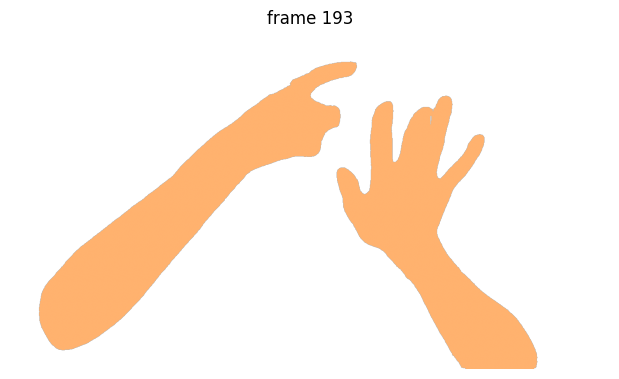

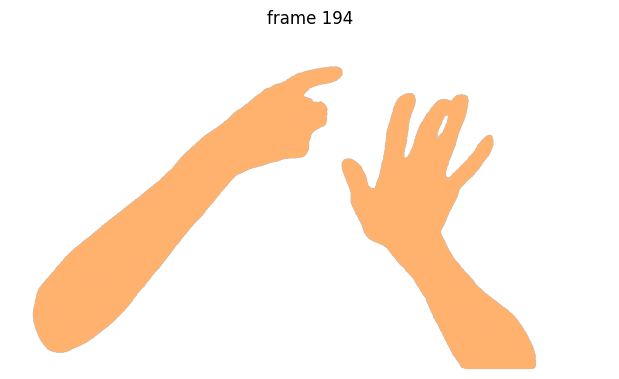

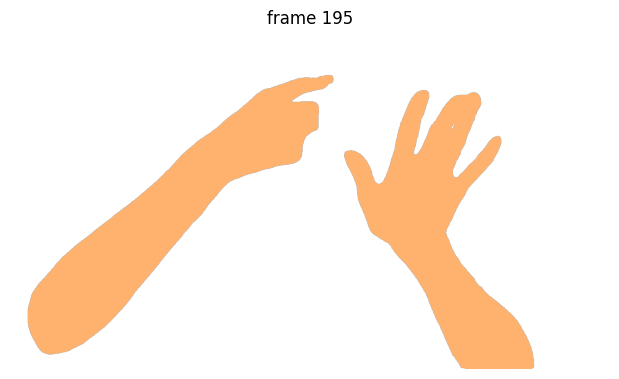

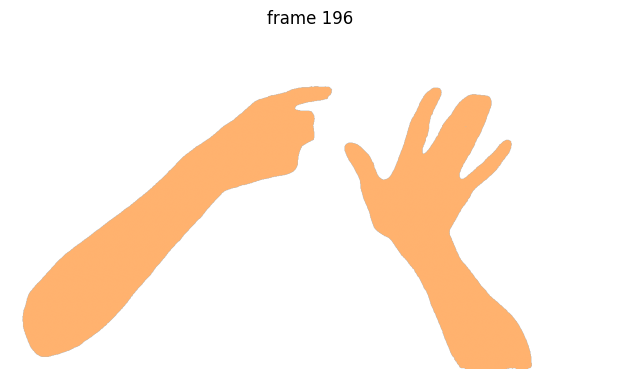

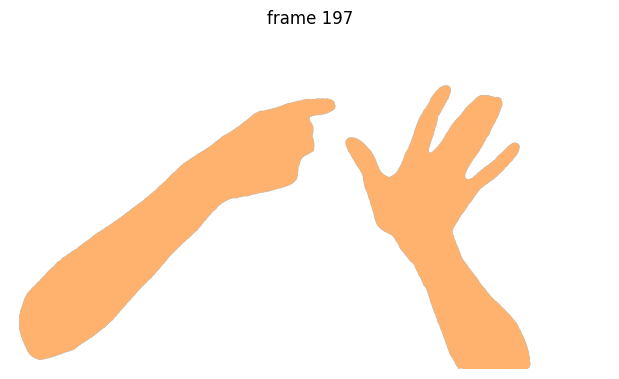

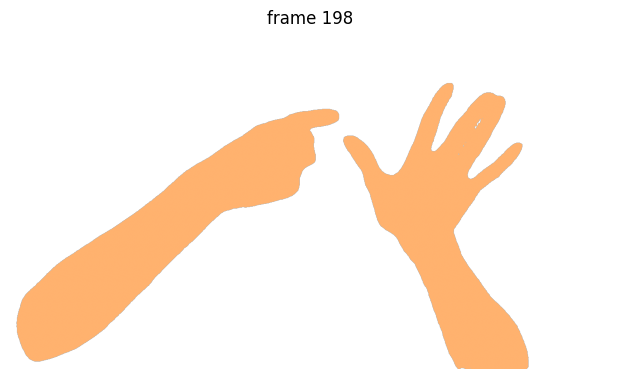

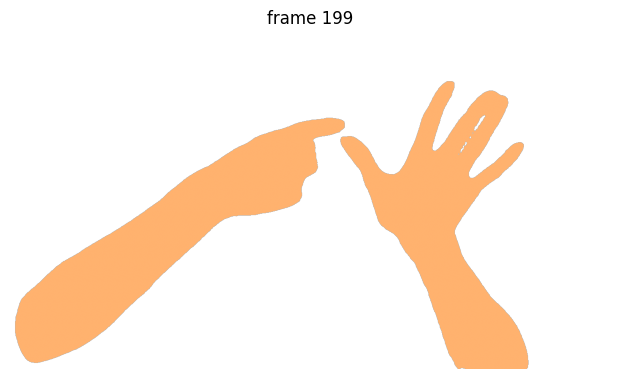

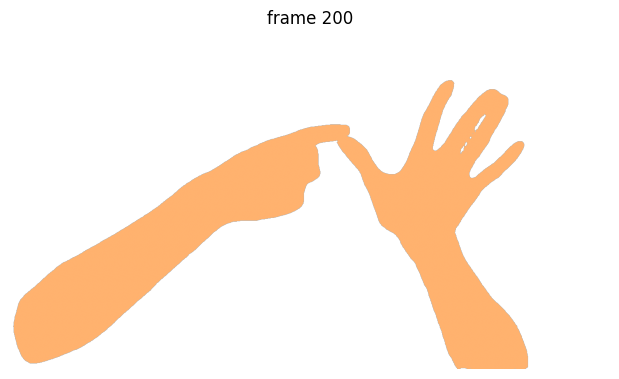

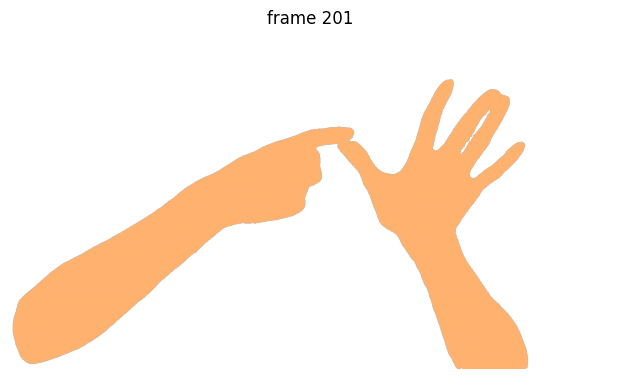

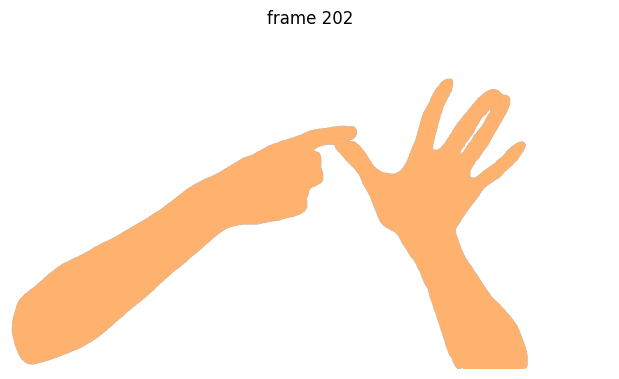

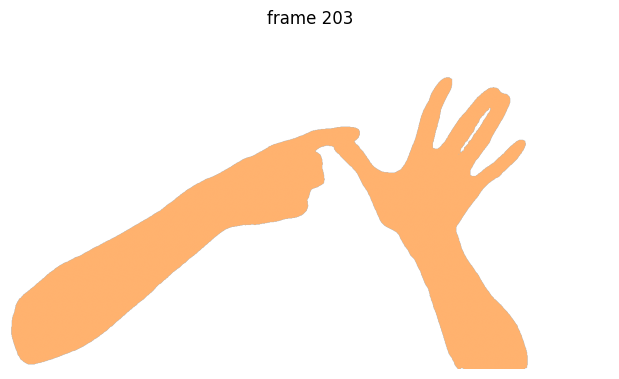

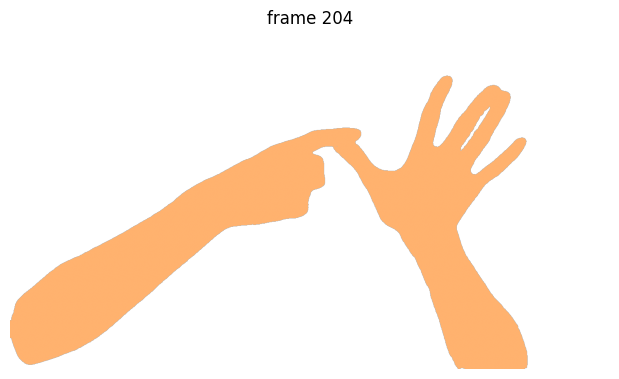

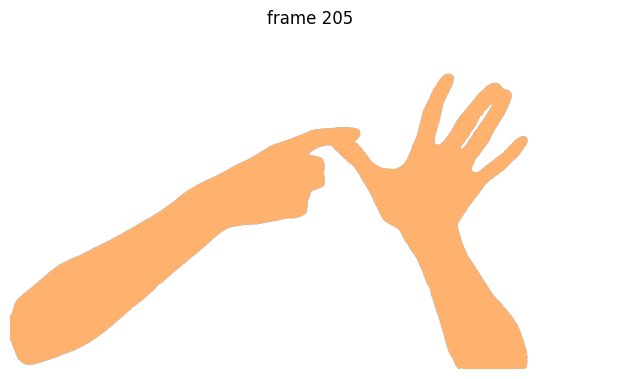

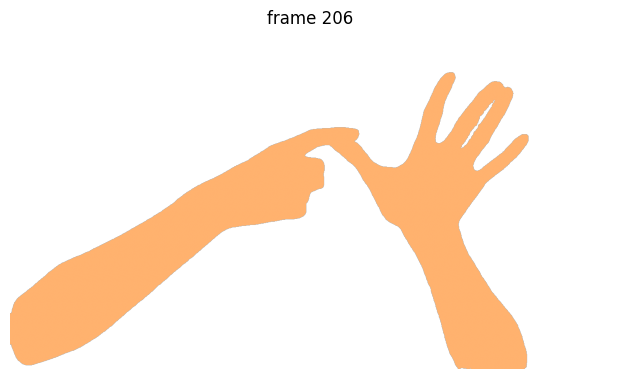

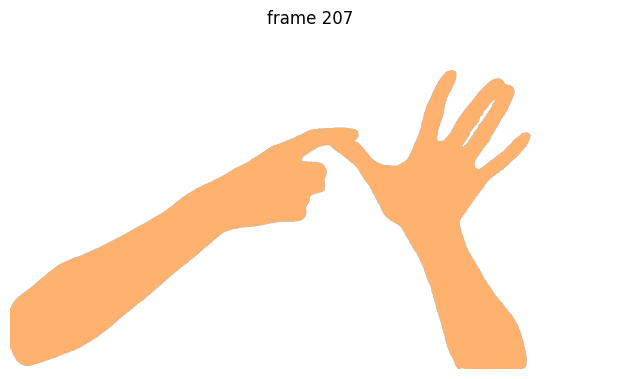

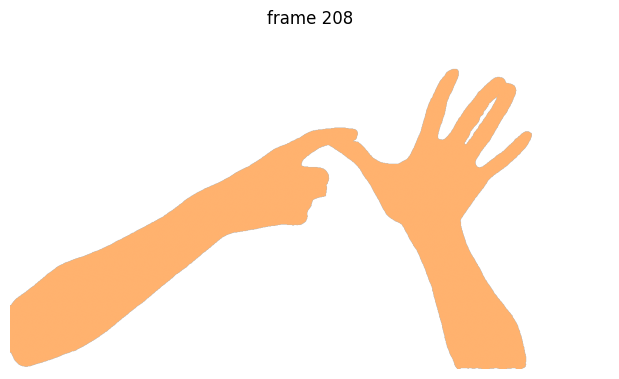

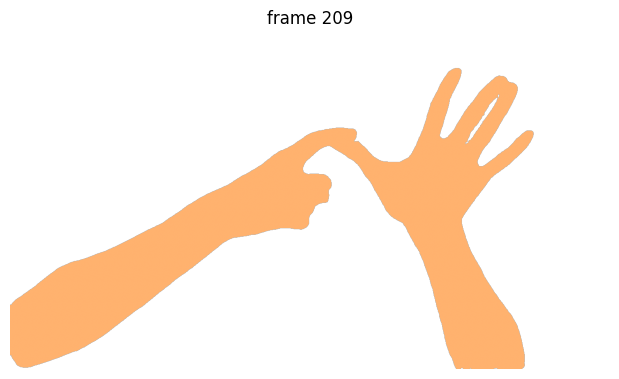

In [25]:
output_video_path = 'output_video.mp4' 
frame_size = (640, 480)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
fps = 30  
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

#loop through all the video frames in video_segments and render them
for out_frame_idx in range(len(video_segments)):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")

    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
    frame = Image.open(frame_path)
    frame = np.array(frame.convert('RGB'))

    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    plt.axis('off')
    plt.tight_layout(pad=0)
    fig = plt.gcf()
    fig.canvas.draw()

    width, height = fig.canvas.get_width_height()
    buf = fig.canvas.print_to_buffer()
    img_array = np.frombuffer(buf[0], dtype=np.uint8).reshape(height, width, 4)

    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    img_resized = cv2.resize(img_rgb, frame_size)
    video_writer.write(img_resized)
    
video_writer.release()
cv2.destroyAllWindows()
print(f"video saved in {output_video_path}")
